In [1]:
import os
import sys

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from weaviate_rag.rag_system import GraphRAGSystem
import ollama
from ragas import evaluate
from ragas.metrics import Faithfulness, AnswerRelevancy, ContextRecall
import re
from ragas import EvaluationDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Device set to use mps:0


In [2]:
# Load your JSON data
# with open('/Users/alexlecu/PycharmProjects/LLMKGraph/backend/evaluation/data/grok_evaluation_dataset_mini/True_or_False_questions_mini.json', 'r') as f:
with open('/Users/alexlecu/PycharmProjects/LLMKGraph/backend/evaluation/data/grok_evaluation_datasets/2_Hop_MCQ_Questions.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame for analysis
df = pd.DataFrame(data)
df = df[['question', 'answer']]

# Add columns for evaluation
df['contexts'] = None  # Will be filled with retrieved passages
df['with_context_answer'] = None  # Will be filled with RAG responses
df['without_context_answer'] = None  # Will be filled with model-only responses

In [3]:
def generate_answer_with_context(question, context, model="llama3.2"):
    """Generate answer using the model with context - simplified prompt"""
    # More direct prompt focused on true/false determination
    system_prompt = f"""
    Given the following medical information, select the correct answer from the options provided (A, B, C, D).
    
    INFORMATION:
    {context}
    
    IMPORTANT: Respond with ONLY the letter of the correct option (e.g., "A", "B", "C", or "D").
    """
   
    response = ollama.chat(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question}
        ],
        stream=False
    )
    return response['message']['content']

In [4]:
def generate_answer_without_context(question, model="llama3.2"):
    """Generate answer using the model without context"""
    system_prompt = """
    Select the correct answer from the options provided (A, B, C, D).
    
    IMPORTANT: Respond with ONLY the letter of the correct option (e.g., "A", "B", "C", or "D").
    """
    
    response = ollama.chat(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question}
        ],
        stream=False
    )
    return response['message']['content']

In [5]:
def remove_think_tags(response):
    """Remove any thinking tags from the response"""
    if response is None:
        return ""
    cleaned_content = re.sub(r'<think>.*?</think>', '', response, flags=re.DOTALL)
    return cleaned_content

In [6]:
def parse_true_false(response):
    """Parse the response to extract True/False answer"""
    if response is None:
        return None
        
    # Clean up response
    response = response.strip().lower()
    
    # Check for True/False keywords
    if "true" in response:
        return True
    elif "false" in response:
        return False
    else:
        print(f"Warning: Could not parse true/false from: '{response}'")
        return None

In [7]:
# Loop through questions and generate answers with context
contexts = []
with_context_responses = []

print("Processing questions with context...")
for index, row in df.iterrows():
    # Retrieve context
    analyzer = GraphRAGSystem(row["question"])
    context = analyzer.analyze()

    contexts.append(context)
    
    # Generate answer with context
    response = generate_answer_with_context(row["question"], context, "llama3.2")
    response = remove_think_tags(response)
    with_context_responses.append(response)
    
    print(f"Question {index+1}: {row['question']}")
    print(f"Context: {context[0][:100]}...")
    print(f"Response: {response}\n")

# Add to dataframe
df['contexts'] = contexts
df['with_context_answer'] = with_context_responses

Processing questions with context...
Question 1: Which factor increases wet AMD risk by promoting VEGF production? a) Smoking b) Drinking water c) Regular exercise d) Low cholesterol
Context: T...
Response: d)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57651), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 2: Can dry AMD progress to geographic atrophy due to excessive antioxidant deficiency? a) Yes b) No c) Only with smoking d) Only with UV exposure
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57685), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 3: Does family history elevate AMD risk by increasing drusen formation susceptibility? a) Yes b) No c) Only in men d) Only in women
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57709), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 4: Can anti-VEGF injections treat wet AMD by reducing photoreceptor regeneration? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57741), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 5: Does hypertension worsen AMD by elevating choroidal pressure? a) Yes b) No c) Only with diabetes d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57767), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 6: Can the Amsler grid detect wet AMD by revealing optic nerve damage? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57800), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 7: Does UV exposure accelerate AMD by triggering immediate retinal hemorrhages? a) Yes b) No c) Only with smoking d) Only with light eyes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57825), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 8: Can AREDS supplements slow dry AMD by reversing retinal pigment epithelial atrophy? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57867), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 9: Does obesity increase AMD risk by enhancing retinal inflammation? a) Yes b) No c) Only with diabetes d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57896), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 10: Can wet AMD cause sudden vision loss by inducing choroidal neovascular leakage? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57941), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 11: Does diabetes heighten AMD risk by causing direct photoreceptor loss? a) Yes b) No c) Sometimes d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57968), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 12: Can OCT diagnose wet AMD by detecting retinal pigment epithelial detachment? a) Yes b) No c) Only late stages d) Only with drusen
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58004), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 13: Does smoking worsen dry AMD by accelerating oxidative damage to the macula? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58027), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 14: Can photodynamic therapy manage wet AMD by reversing drusen accumulation? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58059), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 15: Does a diet rich in leafy greens reduce AMD risk by repairing choroidal blood vessels? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58090), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 16: Can wet AMD cause legal blindness by impairing retinal pigment epithelial regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58128), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 17: Does high cholesterol increase AMD risk by promoting retinal pigment epithelial inflammation? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58159), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 18: Can dry AMD transition to wet AMD due to excessive retinal hypoxia? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58201), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 19: Does AMD impair depth perception by causing choroidal thinning? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: The correct answer is: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58272), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 20: Can anti-VEGF therapy stabilize wet AMD by reducing subretinal fluid leakage? a) Yes b) No c) Only early stages d) Only with surgery
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58330), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 21: Does family history increase AMD risk by causing direct retinal thinning? a) Yes b) No c) Sometimes d) Only with smoking
Context: T...
Response: c) Sometimes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58394), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 22: Can wet AMD distort vision by inducing subretinal hemorrhages? a) Yes b) No c) Only with drusen d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58452), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 23: Does dry AMD progress slowly because it avoids retinal pigment epithelial repair? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58489), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 24: Can hypertension exacerbate AMD by causing retinal pigment epithelial detachment? a) Yes b) No c) Only with diabetes d) Only with obesity
Context: A...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58514), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 25: Does smoking worsen AMD by increasing retinal pigment epithelial hypoxia? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58560), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 26: Can OCT detect early dry AMD by identifying changes in drusen morphology? a) Yes b) No c) Only late stages d) Only with fluid
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58591), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 27: Does wet AMD treatment with anti-VEGF injections work by reversing choroidal neovascularization? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58623), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 28: Can diabetes contribute to AMD by elevating oxidative stress in the retina? a) Yes b) No c) Only with smoking d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58656), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 29: Does dry AMD progress to geographic atrophy by causing retinal pigment epithelial hemorrhages? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58697), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 30: Can AMD increase fall risk by reducing central visual acuity? a) Yes b) No c) Only with wet AMD d) Only with dry AMD
Context: T...
Response: a) Yes. According to the information provided, there is a relationship (relation 131) between AMD and central visual acuity loss, suggesting that AMD can increase fall risk by reducing central visual acuity.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58728), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 31: Does UV exposure accelerate AMD by causing immediate retinal pigment epithelial detachment? a) Yes b) No c) Only with smoking d) Only with light eyes
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58779), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 32: Can wet AMD cause rapid vision loss by inducing retinal pigment epithelial scarring? a) Yes b) No c) Only with drusen d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58821), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 33: Does a diet high in antioxidants prevent AMD by reversing retinal hypoxia? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58856), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 34: Can smoking exacerbate wet AMD by increasing choroidal neovascular activity? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58891), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 35: Does dry AMD affect color perception by causing retinal pigment epithelial regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58922), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 36: Can photodynamic therapy treat wet AMD by reducing retinal pigment epithelial edema? a) Yes b) No c) Only early stages d) Only with anti-VEGF
Context: P...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58959), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 37: Does obesity increase AMD risk by causing immediate retinal pigment epithelial atrophy? a) Yes b) No c) Sometimes d) Only with diabetes
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=99, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59058), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 38: Can wet AMD impair reading by causing retinal pigment epithelial detachment? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59099), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 39: Does high cholesterol contribute to AMD by increasing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with hypertension d) Only with diabetes
Context: H...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59130), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 40: Can AREDS supplements reduce AMD progression by fully repairing retinal pigment epithelium? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: c) Partially



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59172), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 41: Does wet AMD cause blind spots by inducing retinal pigment epithelial regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59207), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 42: Can family history increase AMD risk by predisposing to retinal pigment epithelial oxidative stress? a) Yes b) No c) Only with smoking d) Only with UV exposure
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59239), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 43: Does dry AMD progress to wet AMD due to excessive dietary cholesterol alone? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59287), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 44: Can anti-VEGF injections improve wet AMD by reducing retinal pigment epithelial hemorrhages? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59318), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 45: Does UV light increase AMD risk by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Sometimes d) Only with light eyes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59363), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 46: Can wet AMD affect face recognition by causing retinal pigment epithelial scarring? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59431), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 47: Does hypertension worsen AMD by causing retinal pigment epithelial regeneration? a) Yes b) No c) Only with diabetes d) Only with high cholesterol
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59464), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 48: Can smoking exacerbate AMD by increasing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with obesity d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59505), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 49: Does dry AMD cause gradual vision loss by inducing retinal pigment epithelial repair? a) Yes b) No c) Sometimes d) Only late stages
Context: D...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59554), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 50: Can OCT confirm wet AMD by detecting retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only late stages d) Only with drusen
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59582), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 51: Does diabetes increase AMD risk by causing retinal pigment epithelial hemorrhages? a) Yes b) No c) Only with hypertension d) Only with smoking
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59619), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 52: Can wet AMD cause sudden vision changes by inducing retinal pigment epithelial edema? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59677), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 53: Does family history elevate AMD risk by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59707), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 54: Can anti-VEGF therapy stabilize wet AMD by reducing retinal pigment epithelial scarring? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59742), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 55: Does smoking increase dry AMD risk by causing retinal pigment epithelial edema? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59778), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 56: Can wet AMD impair driving by inducing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59807), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 57: Does high cholesterol exacerbate AMD by causing retinal pigment epithelial repair? a) Yes b) No c) Only with diabetes d) Only with hypertension
Context: H...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59834), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 58: Can AREDS supplements mitigate AMD risk by reversing retinal pigment epithelial swelling? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59871), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 59: Does wet AMD cause depth perception issues by inducing retinal pigment epithelial regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59903), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 60: Can obesity worsen AMD by increasing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59934), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 61: Does dry AMD progress to geographic atrophy due to retinal pigment epithelial lipid repair? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59971), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 62: Can photodynamic therapy treat wet AMD by reducing retinal pigment epithelial hypoxia? a) Yes b) No c) Only early stages d) Only with anti-VEGF
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59999), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 63: Does UV light exposure increase AMD risk by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Sometimes d) Only with light eyes
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60026), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 64: Can wet AMD cause visual hallucinations by inducing retinal pigment epithelial edema? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60063), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 65: Does hypertension contribute to AMD by causing retinal pigment epithelial swelling? a) Yes b) No c) Only with diabetes d) Only with high cholesterol
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60098), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 66: Can smoking increase AMD severity by promoting retinal pigment epithelial atrophy? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60134), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 67: Does dry AMD impair reading by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60158), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 68: Can OCT detect early AMD by visualizing retinal pigment epithelial hypoxia? a) Yes b) No c) Only late stages d) Only with drusen
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60183), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 69: Does diabetes exacerbate AMD by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Only with hypertension d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60206), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 70: Can wet AMD cause sudden vision changes by inducing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60241), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 71: Does family history elevate AMD risk by causing retinal pigment epithelial repair? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60269), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 72: Can anti-VEGF therapy improve wet AMD by reducing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60303), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 73: Does smoking increase AMD risk by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60341), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 74: Can wet AMD impair driving by inducing retinal pigment epithelial edema? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60374), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 75: Does high cholesterol exacerbate AMD by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Only with diabetes d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60402), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 76: Can AREDS supplements mitigate AMD risk by reversing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60440), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 77: Does wet AMD cause depth perception issues by inducing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60473), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 78: Can obesity worsen AMD by increasing retinal pigment epithelial scarring? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: O...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60502), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 79: Does dry AMD progress to geographic atrophy due to retinal pigment epithelial edema? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60542), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 80: Can photodynamic therapy treat wet AMD by reducing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only early stages d) Only with anti-VEGF
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60566), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 81: Does UV light exposure increase AMD risk by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Sometimes d) Only with light eyes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60590), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 82: Can wet AMD cause visual hallucinations by inducing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60635), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 83: Does hypertension contribute to AMD by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Only with diabetes d) Only with high cholesterol
Context: T...
Response: The correct answer is: b) No. 

According to the information, there is no mention of hypertnension contributing to AMD through retinal pigment epithelial lipid regeneration. However, it does show that hypertension aggravates microvascular aging processes and causes AMD occurrence (relation 31).



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60686), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 84: Can smoking increase AMD severity by promoting retinal pigment epithelial edema? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60724), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 85: Does dry AMD impair reading by causing retinal pigment epithelial lipid deposits? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60748), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 86: Can OCT diagnose wet AMD by detecting retinal pigment epithelial edema? a) Yes b) No c) Only late stages d) Only with drusen
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60769), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 87: Does diabetes increase AMD risk by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Only with hypertension d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60799), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 88: Can wet AMD cause sudden vision changes by inducing retinal pigment epithelial scarring? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60846), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 89: Does family history elevate AMD risk by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60880), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 90: Can anti-VEGF therapy improve wet AMD by reducing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60920), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 91: Does smoking increase AMD risk by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60975), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 92: Does smoking exacerbate wet AMD by increasing choroidal neovascularization? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61012), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 93: Can dry AMD progress to wet AMD due to excessive retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with smoking d) Only with diabetes
Context: T...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61047), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 94: Does family history increase AMD risk by predisposing to retinal pigment epithelial atrophy? a) Yes b) No c) Only in women d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61087), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 95: Can anti-VEGF injections treat wet AMD by reversing retinal pigment epithelial damage? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61118), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 96: Does high blood pressure worsen AMD by causing retinal pigment epithelial hemorrhages? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: H...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61151), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 97: Can the Amsler grid detect wet AMD by assessing retinal pigment epithelial lipid changes? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61192), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 98: Does UV light exposure accelerate AMD by causing retinal pigment epithelial swelling? a) Yes b) No c) Only with light eyes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61221), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 99: Can AREDS supplements slow dry AMD by repairing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61259), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 100: Does obesity heighten AMD risk by promoting retinal pigment epithelial scarring? a) Yes b) No c) Only with diabetes d) Only with hypertension
Context: S...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61297), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 101: Can wet AMD cause sudden vision loss by inducing retinal pigment epithelial detachment? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: A...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61343), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 102: Does diabetes increase AMD risk by causing retinal pigment epithelial regeneration? a) Yes b) No c) Only with smoking d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61378), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 103: Can OCT diagnose wet AMD by visualizing subretinal fluid leakage? a) Yes b) No c) Only late stages d) Only with drusen
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61422), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 104: Does smoking worsen dry AMD by increasing retinal pigment epithelial oxidative stress? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61452), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 105: Can photodynamic therapy manage wet AMD by reversing retinal pigment epithelial atrophy? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61489), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 106: Does a diet high in leafy greens reduce AMD progression by eliminating retinal pigment epithelial lipid deposits? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61523), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 107: Can wet AMD lead to legal blindness by causing retinal pigment epithelial repair? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61549), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 108: Does high cholesterol increase AMD risk by causing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: H...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61583), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 109: Can dry AMD transition to wet AMD due to excessive choroidal neovascular activity? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61627), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 110: Does AMD impair color perception by inducing retinal pigment epithelial regeneration? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61655), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 111: Can anti-VEGF therapy stabilize wet AMD by reducing retinal pigment epithelial edema? a) Yes b) No c) Only early stages d) Only with surgery
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61685), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 112: Does family history increase AMD risk by causing retinal pigment epithelial hemorrhages? a) Yes b) No c) Sometimes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61723), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 113: Can wet AMD distort vision by causing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with drusen d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61772), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 114: Does dry AMD progress slowly because it avoids retinal pigment epithelial swelling? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61798), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 115: Can high blood pressure exacerbate AMD by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Only with diabetes d) Only with obesity
Context: H...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61824), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 116: Does smoking worsen AMD by increasing retinal pigment epithelial scarring? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61859), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 117: Can OCT detect early dry AMD by identifying retinal pigment epithelial thinning? a) Yes b) No c) Only late stages d) Only with fluid
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61895), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 118: Does wet AMD treatment with anti-VEGF injections work by reversing retinal pigment epithelial lipid deposits? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61933), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 119: Can diabetes contribute to AMD by increasing retinal pigment epithelial inflammation? a) Yes b) No c) Only with smoking d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61968), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 120: Does dry AMD progress to geographic atrophy by causing retinal pigment epithelial regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62001), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 121: Can AMD increase fall risk by impairing retinal pigment epithelial function? a) Yes b) No c) Only with wet AMD d) Only with dry AMD
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62039), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 122: Does UV exposure accelerate AMD by causing retinal pigment epithelial hemorrhages? a) Yes b) No c) Only with smoking d) Only with light eyes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62076), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 123: Can wet AMD cause rapid vision loss by inducing retinal pigment epithelial atrophy? a) Yes b) No c) Only with drusen d) Only with hypertension
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62117), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 124: Does a diet high in antioxidants prevent AMD by reversing retinal pigment epithelial swelling? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62151), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 125: Can smoking exacerbate wet AMD by increasing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62183), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 126: Does dry AMD affect color perception by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62209), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 127: Can photodynamic therapy treat wet AMD by reducing retinal pigment epithelial scarring? a) Yes b) No c) Only early stages d) Only with anti-VEGF
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62240), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 128: Does obesity increase AMD risk by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Sometimes d) Only with diabetes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62275), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 129: Can wet AMD impair reading by causing retinal pigment epithelial edema? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62312), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 130: Does high cholesterol contribute to AMD by increasing retinal pigment epithelial repair? a) Yes b) No c) Only with hypertension d) Only with diabetes
Context: H...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62340), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 131: Can AREDS supplements reduce AMD progression by reversing retinal pigment epithelial hemorrhages? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62375), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 132: Does wet AMD cause blind spots by inducing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62401), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 133: Can family history increase AMD risk by predisposing to retinal pigment epithelial scarring? a) Yes b) No c) Only with smoking d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62430), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 134: Does dry AMD progress to wet AMD due to excessive retinal pigment epithelial lipid repair? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62470), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 135: Can anti-VEGF injections improve wet AMD by reducing retinal pigment epithelial atrophy? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62504), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 136: Does UV light increase AMD risk by causing retinal pigment epithelial lipid hemorrhages? a) Yes b) No c) Sometimes d) Only with light eyes
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62542), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 137: Can wet AMD affect face recognition by causing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62585), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 138: Does hypertension worsen AMD by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Only with diabetes d) Only with high cholesterol
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62616), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 139: Can smoking exacerbate AMD by increasing retinal pigment epithelial atrophy? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62658), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 140: Does dry AMD cause gradual vision loss by inducing retinal pigment epithelial lipid deposits? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62690), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 141: Can OCT confirm wet AMD by detecting retinal pigment epithelial scarring? a) Yes b) No c) Only late stages d) Only with drusen
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62723), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 142: Can wet AMD cause sudden vision changes by inducing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62755), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 143: Can anti-VEGF therapy stabilize wet AMD by reducing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62786), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 144: Does smoking increase dry AMD risk by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62825), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 145: Can wet AMD impair driving by causing retinal pigment epithelial atrophy? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62851), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 146: Does high cholesterol exacerbate AMD by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Only with diabetes d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62875), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 147: Can AREDS supplements mitigate AMD risk by reversing retinal pigment epithelial lipid deposits? a) Yes b) No c) Partially d) Only with zinc
Context: A...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62913), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 148: Does wet AMD cause depth perception issues by inducing retinal pigment epithelial lipid repair? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62950), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 149: Can obesity worsen AMD by increasing retinal pigment epithelial edema? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62980), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 150: Does dry AMD progress to geographic atrophy due to retinal pigment epithelial lipid regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: c) Sometimes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63023), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 151: Can photodynamic therapy treat wet AMD by reducing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only early stages d) Only with anti-VEGF
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63057), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 152: Can wet AMD cause visual hallucinations by causing retinal pigment epithelial atrophy? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63085), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 153: Can smoking increase AMD severity by promoting retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63111), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 154: Can OCT detect early AMD by visualizing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only late stages d) Only with drusen
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63136), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 155: Does smoking increase AMD risk by enhancing retinal pigment epithelial inflammation? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63164), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 156: Can dry AMD progress to wet AMD due to excessive retinal pigment epithelial repair alone? a) Yes b) No c) Only with smoking d) Only with diabetes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63203), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 157: Does family history elevate AMD risk by increasing retinal pigment epithelial susceptibility to oxidative stress? a) Yes b) No c) Only in men d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63241), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 158: Can anti-VEGF injections treat wet AMD by reversing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63283), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 159: Does hypertension worsen AMD by causing retinal pigment epithelial swelling? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63319), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 160: Can the Amsler grid detect wet AMD by measuring retinal pigment epithelial regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63359), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 161: Does UV light exposure accelerate AMD by causing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with light eyes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63386), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 162: Can AREDS supplements slow dry AMD by regenerating retinal pigment epithelial cells? a) Yes b) No c) Partially d) Only with zinc
Context: A...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63435), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 163: Does obesity heighten AMD risk by promoting retinal pigment epithelial hypoxia? a) Yes b) No c) Only with diabetes d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63472), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 164: Can wet AMD cause sudden vision loss by inducing retinal pigment epithelial hemorrhages? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63520), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 165: Does diabetes increase AMD risk by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Only with smoking d) Only with obesity
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63558), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 166: Does smoking worsen dry AMD by increasing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63611), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 167: Can photodynamic therapy manage wet AMD by reversing retinal pigment epithelial lipid deposits? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63646), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 168: Does a diet high in leafy greens reduce AMD progression by repairing retinal pigment epithelial hypoxia? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63680), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 169: Can wet AMD lead to legal blindness by causing retinal pigment epithelial regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63712), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 170: Can dry AMD transition to wet AMD due to retinal pigment epithelial hypoxia? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63750), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 171: Does AMD impair color perception by causing retinal pigment epithelial repair? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63781), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 172: Can anti-VEGF therapy stabilize wet AMD by reducing retinal pigment epithelial fluid leakage? a) Yes b) No c) Only early stages d) Only with surgery
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63812), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 173: Does family history increase AMD risk by causing retinal pigment epithelial edema? a) Yes b) No c) Sometimes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63852), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 174: Can wet AMD distort vision by inducing retinal pigment epithelial scarring? a) Yes b) No c) Only with drusen d) Only with hypertension
Context: T...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63896), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 175: Does dry AMD progress slowly because it avoids retinal pigment epithelial regeneration? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63922), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 176: Can hypertension exacerbate AMD by causing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with diabetes d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63947), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 177: Does smoking worsen AMD by promoting retinal pigment epithelial edema? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: The correct answer is: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64001), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 178: Can OCT detect early dry AMD by visualizing retinal pigment epithelial atrophy? a) Yes b) No c) Only late stages d) Only with fluid
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64046), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 179: Does wet AMD treatment with anti-VEGF injections work by reversing retinal pigment epithelial hypoxia? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64152), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 180: Can diabetes contribute to AMD by increasing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with smoking d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64285), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 181: Does dry AMD progress to geographic atrophy by causing retinal pigment epithelial swelling? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64388), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 182: Can AMD increase fall risk by impairing retinal pigment epithelial acuity? a) Yes b) No c) Only with wet AMD d) Only with dry AMD
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64427), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 183: Does UV exposure accelerate AMD by causing retinal pigment epithelial regeneration? a) Yes b) No c) Only with smoking d) Only with light eyes
Context: T...
Response: c) Only with smoking



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64482), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 184: Can wet AMD cause rapid vision loss by inducing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with drusen d) Only with hypertension
Context: A...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64526), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 185: Does a diet high in antioxidants prevent AMD by reversing retinal pigment epithelial lipid deposits? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64567), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 186: Can smoking exacerbate wet AMD by increasing retinal pigment epithelial scarring? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64615), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 187: Does dry AMD affect color perception by causing retinal pigment epithelial hemorrhages? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64659), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 188: Can photodynamic therapy manage wet AMD by reducing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only early stages d) Only with anti-VEGF
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64698), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 189: Does obesity increase AMD risk by causing retinal pigment epithelial repair? a) Yes b) No c) Sometimes d) Only with diabetes
Context: O...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64729), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 190: Can wet AMD impair reading by causing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64767), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 191: Does high cholesterol contribute to AMD by causing retinal pigment epithelial edema? a) Yes b) No c) Only with hypertension d) Only with diabetes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64792), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 192: Can AREDS supplements reduce AMD progression by reversing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64834), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 193: Does wet AMD cause blind spots by inducing retinal pigment epithelial swelling? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64857), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 194: Can family history increase AMD risk by predisposing to retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with smoking d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64883), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 195: Does dry AMD progress to wet AMD due to excessive retinal pigment epithelial lipid regeneration? a) Yes b) No c) Sometimes d) Only with obesity
Context: S...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64922), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 196: Does UV light increase AMD risk by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Sometimes d) Only with light eyes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64952), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 197: Can wet AMD affect face recognition by causing retinal pigment epithelial edema? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64987), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 198: Does hypertension worsen AMD by causing retinal pigment epithelial repair? a) Yes b) No c) Only with diabetes d) Only with high cholesterol
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65020), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 199: Can smoking exacerbate AMD by increasing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65062), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 200: Does dry AMD cause gradual vision loss by inducing retinal pigment epithelial regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65092), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 201: Can anti-VEGF therapy stabilize wet AMD by reducing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65131), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 202: Does smoking increase dry AMD risk by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: B...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65172), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 203: Can wet AMD impair driving by inducing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65198), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 204: Can obesity worsen AMD by increasing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65222), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 205: Can wet AMD cause visual hallucinations by inducing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with drusen d) Only with smoking
Context: A...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65264), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 206: Does hypertension contribute to AMD by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Only with diabetes d) Only with high cholesterol
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65297), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 207: Can smoking increase AMD severity by promoting retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65334), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 208: Does diabetes exacerbate AMD by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Only with hypertension d) Only with smoking
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65362), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 209: Does smoking worsen AMD by increasing retinal pigment epithelial atrophy? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65399), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 210: Can dry AMD progress to wet AMD due to excessive retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with smoking d) Only with diabetes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65432), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 211: Does family history increase AMD risk by predisposing to retinal pigment epithelial lipid deposits? a) Yes b) No c) Only in women d) Only with hypertension
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65472), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 212: Can anti-VEGF injections treat wet AMD by reversing retinal pigment epithelial atrophy? a) Yes b) No c) Partially d) Only early stages
Context: I...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65535), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 213: Does hypertension exacerbate AMD by causing retinal pigment epithelial edema? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: A...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49192), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 214: Can the Amsler grid detect wet AMD by assessing retinal pigment epithelial swelling? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49235), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 215: Does UV light exposure accelerate AMD by causing retinal pigment epithelial repair? a) Yes b) No c) Only with light eyes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49264), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 216: Can AREDS supplements slow dry AMD by reversing retinal pigment epithelial lipid deposits? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49307), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 217: Does obesity increase AMD risk by promoting retinal pigment epithelial edema? a) Yes b) No c) Only with diabetes d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49342), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 218: Can wet AMD cause sudden vision loss by inducing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49396), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 219: Does diabetes heighten AMD risk by causing retinal pigment epithelial repair? a) Yes b) No c) Only with smoking d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49439), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 220: Can OCT diagnose wet AMD by detecting retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only late stages d) Only with drusen
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49500), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 221: Does smoking worsen dry AMD by promoting retinal pigment epithelial scarring? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49539), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 222: Can photodynamic therapy manage wet AMD by reversing retinal pigment epithelial edema? a) Yes b) No c) Sometimes d) Only early stages
Context: P...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49577), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 223: Does a diet high in leafy greens reduce AMD progression by eliminating retinal pigment epithelial atrophy? a) Yes b) No c) Partially d) Only with supplements
Context: A...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49617), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 224: Can wet AMD lead to legal blindness by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49650), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 225: Does high cholesterol increase AMD risk by causing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49689), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 226: Can dry AMD transition to wet AMD due to retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49745), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 227: Does AMD impair color perception by causing retinal pigment epithelial regeneration? a) Yes b) No c) Sometimes d) Only wet AMD
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49782), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 228: Can anti-VEGF therapy stabilize wet AMD by reducing retinal pigment epithelial hemorrhages? a) Yes b) No c) Only early stages d) Only with surgery
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49815), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 229: Does family history increase AMD risk by causing retinal pigment epithelial swelling? a) Yes b) No c) Sometimes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49870), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 230: Can wet AMD distort vision by causing retinal pigment epithelial edema? a) Yes b) No c) Only with drusen d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49916), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 231: Does dry AMD progress slowly because it avoids retinal pigment epithelial lipid repair? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49955), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 232: Can hypertension exacerbate AMD by causing retinal pigment epithelial repair? a) Yes b) No c) Only with diabetes d) Only with obesity
Context: H...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49985), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 233: Does smoking worsen AMD by increasing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50039), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 234: Can OCT detect early dry AMD by identifying retinal pigment epithelial lipid deposits? a) Yes b) No c) Only late stages d) Only with fluid
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50081), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 235: Does wet AMD treatment with anti-VEGF injections work by reversing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50122), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 236: Can diabetes contribute to AMD by increasing retinal pigment epithelial edema? a) Yes b) No c) Only with smoking d) Only with hypertension
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50168), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 237: Does dry AMD progress to geographic atrophy by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50212), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 238: Can AMD increase fall risk by impairing retinal pigment epithelial lipid metabolism? a) Yes b) No c) Only with wet AMD d) Only with dry AMD
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50250), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 239: Does UV exposure accelerate AMD by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Only with smoking d) Only with light eyes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50309), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 240: Can wet AMD cause rapid vision loss by inducing retinal pigment epithelial edema? a) Yes b) No c) Only with drusen d) Only with hypertension
Context: W...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50354), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 241: Does a diet high in antioxidants prevent AMD by reversing retinal pigment epithelial edema? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50402), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 242: Can smoking exacerbate wet AMD by increasing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50454), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 243: Does dry AMD affect color perception by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50495), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 244: Does obesity increase AMD risk by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Sometimes d) Only with diabetes
Context: O...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50531), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 245: Can wet AMD impair reading by causing retinal pigment epithelial swelling? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50578), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 246: Does high cholesterol contribute to AMD by causing retinal pigment epithelial lipid regeneration? a) Yes b) No c) Only with hypertension d) Only with diabetes
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50610), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 247: Can AREDS supplements reduce AMD progression by reversing retinal pigment epithelial edema? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: c) Partially



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50659), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 248: Does wet AMD cause blind spots by inducing retinal pigment epithelial lipid deposits? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50694), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 249: Can family history increase AMD risk by predisposing to retinal pigment epithelial edema? a) Yes b) No c) Only with smoking d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50725), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 250: Does dry AMD progress to wet AMD due to retinal pigment epithelial lipid deposits? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50773), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 251: Can anti-VEGF injections improve wet AMD by reducing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50811), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 252: Can wet AMD affect face recognition by causing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50864), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 253: Does hypertension worsen AMD by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Only with diabetes d) Only with high cholesterol
Context: T...
Response: c)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50902), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 254: Can smoking exacerbate AMD by increasing retinal pigment epithelial edema? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50949), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 255: Can OCT confirm wet AMD by detecting retinal pigment epithelial edema? a) Yes b) No c) Only late stages d) Only with drusen
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50990), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 256: Does smoking exacerbate AMD by increasing retinal pigment epithelial oxidative damage? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51029), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 257: Can dry AMD progress to wet AMD due to excessive choroidal inflammation alone? a) Yes b) No c) Only with smoking d) Only with diabetes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51067), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 258: Does family history elevate AMD risk by increasing susceptibility to retinal pigment epithelial degeneration? a) Yes b) No c) Only in men d) Only with hypertension
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51122), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 259: Can anti-VEGF injections treat wet AMD by reversing choroidal neovascular growth? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51170), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 260: Does hypertension worsen AMD by causing choroidal vascular leakage? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51206), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 261: Can the Amsler grid detect wet AMD by revealing retinal pigment epithelial detachment? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51256), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 262: Does UV light exposure accelerate AMD by triggering choroidal neovascularization? a) Yes b) No c) Only with light eyes d) Only with smoking
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51293), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 263: Can AREDS supplements slow dry AMD by repairing photoreceptor damage? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51348), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 264: Does obesity heighten AMD risk by increasing retinal pigment epithelial stress? a) Yes b) No c) Only with diabetes d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51387), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 265: Can wet AMD cause sudden vision loss by inducing subretinal fluid buildup? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51441), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 266: Does diabetes increase AMD risk by causing photoreceptor degeneration? a) Yes b) No c) Only with smoking d) Only with obesity
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51483), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 267: Can OCT diagnose wet AMD by detecting abnormal choroidal blood vessels? a) Yes b) No c) Only late stages d) Only with drusen
Context: S...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51543), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 268: Does smoking worsen dry AMD by accelerating retinal pigment epithelial atrophy? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51573), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 269: Can photodynamic therapy manage wet AMD by reducing photoreceptor loss? a) Yes b) No c) Sometimes d) Only early stages
Context: P...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51611), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 270: Does a diet rich in leafy greens reduce AMD progression by repairing retinal pigment epithelium? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51649), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 271: Can wet AMD lead to legal blindness by causing peripheral vision loss? a) Yes b) No c) Sometimes d) Only late stages
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51683), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 272: Does high cholesterol increase AMD risk by promoting drusen formation? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: H...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51723), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 273: Can dry AMD transition to wet AMD due to excessive VEGF production? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51780), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 274: Does AMD impair depth perception by causing optic nerve damage? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51815), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 275: Can anti-VEGF therapy stabilize wet AMD by reducing choroidal neovascular leakage? a) Yes b) No c) Only early stages d) Only with surgery
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51848), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 276: Does family history increase AMD risk by causing choroidal thinning? a) Yes b) No c) Sometimes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51894), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 277: Does dry AMD progress slowly because it lacks photoreceptor regeneration? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51936), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 278: Can hypertension exacerbate AMD by increasing retinal pigment epithelial detachment? a) Yes b) No c) Only with diabetes d) Only with obesity
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51965), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 279: Does smoking worsen AMD by enhancing choroidal inflammation? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52014), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 280: Can OCT detect early dry AMD by identifying drusen size increases? a) Yes b) No c) Only late stages d) Only with fluid
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52060), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 281: Does wet AMD treatment with anti-VEGF injections work by regenerating retinal tissue? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52098), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 282: Can diabetes contribute to AMD by elevating retinal inflammation? a) Yes b) No c) Only with smoking d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52135), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 283: Does dry AMD progress to geographic atrophy by causing blood vessel leakage? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52191), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 284: Can AMD increase fall risk by reducing central visual clarity? a) Yes b) No c) Only with wet AMD d) Only with dry AMD
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52221), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 285: Does UV exposure accelerate AMD by causing immediate photoreceptor death? a) Yes b) No c) Only with smoking d) Only with light eyes
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52269), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 286: Can wet AMD cause rapid vision loss by inducing retinal scarring? a) Yes b) No c) Only with drusen d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52317), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 287: Does a diet high in antioxidants prevent AMD by reversing Bruch’s membrane damage? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52356), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 288: Can smoking exacerbate wet AMD by increasing VEGF levels? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52400), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 289: Does dry AMD affect color perception by damaging retinal ganglion cells? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52432), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 290: Can photodynamic therapy treat wet AMD by sealing abnormal blood vessels? a) Yes b) No c) Only early stages d) Only with anti-VEGF
Context: P...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52467), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 291: Does obesity increase AMD risk by causing retinal thinning? a) Yes b) No c) Sometimes d) Only with diabetes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52504), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 292: Can wet AMD impair reading by causing central vision distortion? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52555), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 293: Does high cholesterol contribute to AMD by clogging retinal arteries? a) Yes b) No c) Only with hypertension d) Only with diabetes
Context: T...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52587), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 294: Can AREDS supplements reduce AMD progression by eliminating oxidative stress entirely? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52631), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 295: Does wet AMD cause blind spots by regenerating retinal tissue? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52664), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 296: Can family history increase AMD risk by predisposing to drusen accumulation? a) Yes b) No c) Only with smoking d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52704), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 297: Does dry AMD progress to wet AMD due to excessive screen time alone? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52754), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 298: Can anti-VEGF injections improve wet AMD by reducing fluid leakage? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: A...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52788), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 299: Does UV light increase AMD risk by causing optic nerve atrophy? a) Yes b) No c) Sometimes d) Only with light eyes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52841), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 300: Can wet AMD affect face recognition by distorting central vision? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52886), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 301: Does hypertension worsen AMD by causing retinal hemorrhages? a) Yes b) No c) Only with diabetes d) Only with high cholesterol
Context: T...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52931), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 302: Can smoking exacerbate AMD by increasing retinal oxidative stress? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52984), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 303: Does dry AMD cause vision loss by affecting the choroid directly? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53025), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 304: Can OCT confirm wet AMD by visualizing choroidal neovascularization? a) Yes b) No c) Only late stages d) Only with drusen
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53063), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 305: Does diabetes increase AMD risk by causing retinal artery occlusion? a) Yes b) No c) Only with smoking d) Only with hypertension
Context: T...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53109), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 306: Can wet AMD cause sudden vision changes by inducing retinal edema? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53168), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 307: Does family history elevate AMD risk by increasing lipid deposits in the choroid? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53205), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 308: Can anti-VEGF therapy prevent wet AMD progression by stabilizing retinal thickness? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: A...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53259), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 309: Does smoking increase dry AMD risk by causing choroidal thinning? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53318), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 310: Can wet AMD impair driving by distorting central visual acuity? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53357), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 311: Does high cholesterol exacerbate AMD by causing optic nerve inflammation? a) Yes b) No c) Only with diabetes d) Only with hypertension
Context: H...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53390), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 312: Can AREDS supplements mitigate AMD risk by repairing retinal pigment epithelium? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53436), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 313: Does wet AMD cause depth perception issues by regenerating retinal layers? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53488), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 314: Can obesity worsen AMD by increasing retinal inflammation? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53524), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 315: Does dry AMD progress to geographic atrophy due to excessive neovascularization? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53585), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 316: Can photodynamic therapy treat wet AMD by shrinking choroidal blood vessels? a) Yes b) No c) Only early stages d) Only with anti-VEGF
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53624), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 317: Does UV light exposure increase AMD risk by causing photoreceptor regeneration? a) Yes b) No c) Sometimes d) Only with light eyes
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53661), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 318: Can wet AMD cause visual hallucinations by inducing retinal pigment epithelial scarring? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53710), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 319: Does hypertension contribute to AMD by increasing drusen size? a) Yes b) No c) Only with diabetes d) Only with high cholesterol
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53750), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 320: Can smoking increase AMD severity by promoting photoreceptor degeneration? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53792), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 321: Does dry AMD impair reading by causing optic nerve damage? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53827), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 322: Can OCT detect early AMD by measuring retinal layer thinning? a) Yes b) No c) Only late stages d) Only with drusen
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53853), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 323: Does diabetes exacerbate AMD by causing direct blood vessel leakage? a) Yes b) No c) Only with smoking d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53887), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 324: Can wet AMD affect color perception by causing central vision loss? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53930), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 325: Does family history worsen AMD by causing optic nerve atrophy? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 53968), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 326: Can anti-VEGF injections treat wet AMD by preventing subretinal hemorrhages? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: I...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54007), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 327: Does smoking worsen AMD by causing direct retinal detachment? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54049), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 328: Can wet AMD increase fall risk by impairing central depth perception? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54102), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 329: Does high cholesterol increase AMD risk by causing retinal vein occlusion? a) Yes b) No c) Only with diabetes d) Only with hypertension
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54136), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 330: Can AREDS supplements slow dry AMD by reducing retinal hypoxia? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54196), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 331: Does wet AMD cause rapid vision loss by regenerating choroidal tissue? a) Yes b) No c) Sometimes d) Only late stages
Context: S...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54236), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 332: Can obesity increase AMD risk by enhancing choroidal oxidative stress? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54274), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 333: Does dry AMD progress to wet AMD due to excessive antioxidant intake? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54337), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 334: Can photodynamic therapy manage wet AMD by reducing retinal edema? a) Yes b) No c) Only early stages d) Only with anti-VEGF
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54372), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 335: Does UV light exposure worsen AMD by causing photoreceptor regeneration? a) Yes b) No c) Sometimes d) Only with light eyes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54407), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 336: Can wet AMD impair night vision by distorting central visual fields? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54445), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 337: Does hypertension increase AMD severity by causing optic nerve swelling? a) Yes b) No c) Only with diabetes d) Only with high cholesterol
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54473), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 338: Can smoking exacerbate AMD by increasing choroidal hypoxia? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54515), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 339: Does dry AMD cause blind spots by damaging retinal vasculature? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54559), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 340: Does diabetes increase AMD risk by causing optic nerve inflammation? a) Yes b) No c) Only with smoking d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54599), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 341: Can wet AMD affect reading speed by causing central retinal blur? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes. According to the provided information, wet AMD is characterized by polypoidal choroidal vasculopathy and neovascularization, which can lead to inflammation and oxidative stress, ultimately causing central vision loss and blurred vision (relationships 11, 13, 15, 17, 19, 23).



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54651), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 342: Does family history worsen AMD by causing direct retinal scarring? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54692), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 343: Can anti-VEGF therapy improve wet AMD by reducing choroidal inflammation? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54728), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 344: Does smoking increase AMD risk by causing retinal regeneration? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54783), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 345: Does smoking increase AMD risk by promoting retinal pigment epithelial hypoxia? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54831), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 346: Can dry AMD progress to wet AMD due to excessive retinal pigment epithelial inflammation alone? a) Yes b) No c) Only with smoking d) Only with diabetes
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54880), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 347: Does family history elevate AMD risk by increasing retinal pigment epithelial vulnerability to oxidative stress? a) Yes b) No c) Only in women d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54930), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 348: Can anti-VEGF injections treat wet AMD by reversing retinal pigment epithelial scarring? a) Yes b) No c) Partially d) Only early stages
Context: I...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54988), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 349: Does hypertension worsen AMD by causing retinal pigment epithelial hypoxia? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: A...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55028), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 350: Can the Amsler grid detect wet AMD by measuring retinal pigment epithelial lipid changes? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55084), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 351: Does UV light exposure accelerate AMD by causing retinal pigment epithelial hemorrhages? a) Yes b) No c) Only with light eyes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55120), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 352: Does obesity heighten AMD risk by promoting retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with diabetes d) Only with hypertension
Context: S...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55169), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 353: Does diabetes increase AMD risk by causing retinal pigment epithelial swelling? a) Yes b) No c) Only with smoking d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55225), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 354: Does smoking worsen dry AMD by increasing retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55281), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 355: Can photodynamic therapy manage wet AMD by reversing retinal pigment epithelial damage? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55323), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 356: Does a diet high in leafy greens reduce AMD progression by eliminating retinal pigment epithelial hypoxia? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55363), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 357: Does high cholesterol increase AMD risk by promoting retinal pigment epithelial edema? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: H...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55395), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 358: Can dry AMD transition to wet AMD due to retinal pigment epithelial lipid deposits? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55447), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 359: Does AMD impair color perception by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55502), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 360: Can anti-VEGF therapy stabilize wet AMD by reducing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only early stages d) Only with surgery
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55540), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 361: Can wet AMD distort vision by causing retinal pigment epithelial swelling? a) Yes b) No c) Only with drusen d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55608), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 362: Can hypertension exacerbate AMD by causing retinal pigment epithelial lipid repair? a) Yes b) No c) Only with diabetes d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55650), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 363: Does UV exposure accelerate AMD by causing retinal pigment epithelial swelling? a) Yes b) No c) Only with smoking d) Only with light eyes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55714), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 364: Does a diet high in antioxidants prevent AMD by reversing retinal pigment epithelial atrophy? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55777), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 365: Can smoking exacerbate wet AMD by increasing retinal pigment epithelial edema? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55875), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 366: Does dry AMD affect color perception by causing retinal pigment epithelial repair? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55912), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 367: Does obesity increase AMD risk by causing retinal pigment epithelial regeneration? a) Yes b) No c) Sometimes d) Only with diabetes
Context: O...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55951), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 368: Does high cholesterol contribute to AMD by causing retinal pigment epithelial repair? a) Yes b) No c) Only with hypertension d) Only with diabetes
Context: H...
Response: c)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56014), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 369: Does dry AMD progress to wet AMD due to excessive retinal pigment epithelial repair? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56082), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 370: Can wet AMD impair driving by inducing retinal pigment epithelial atrophy? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56129), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 371: Does smoking exacerbate AMD by increasing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: The correct answer is: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56161), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 372: Can dry AMD progress to wet AMD due to excessive retinal pigment epithelial hypoxia? a) Yes b) No c) Only with smoking d) Only with diabetes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56208), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 373: Does family history elevate AMD risk by increasing retinal pigment epithelial susceptibility to lipid deposits? a) Yes b) No c) Only in men d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56266), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 374: Can anti-VEGF injections treat wet AMD by reducing retinal pigment epithelial inflammation? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56332), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 375: Does hypertension worsen AMD by causing retinal pigment epithelial lipid accumulation? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: T...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56380), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 376: Can the Amsler grid detect wet AMD by identifying retinal pigment epithelial detachment? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56442), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 377: Does UV light exposure accelerate AMD by causing retinal pigment epithelial oxidative stress? a) Yes b) No c) Only with light eyes d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56484), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 378: Can AREDS supplements slow dry AMD by reducing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: c) Partially



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56546), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 379: Does obesity increase AMD risk by enhancing retinal pigment epithelial oxidative damage? a) Yes b) No c) Only with diabetes d) Only with hypertension
Context: S...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56583), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 380: Can wet AMD cause sudden vision loss by inducing retinal pigment epithelial scarring? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: A...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56644), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 381: Does diabetes heighten AMD risk by causing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with smoking d) Only with obesity
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56690), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 382: Can OCT diagnose wet AMD by detecting retinal pigment epithelial lipid deposits? a) Yes b) No c) Only late stages d) Only with drusen
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56755), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 383: Does smoking worsen dry AMD by accelerating retinal pigment epithelial degeneration? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56789), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 384: Can photodynamic therapy manage wet AMD by reducing retinal pigment epithelial edema? a) Yes b) No c) Sometimes d) Only early stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56832), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 385: Does a diet rich in leafy greens reduce AMD progression by repairing retinal pigment epithelial damage? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56879), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 386: Can wet AMD lead to legal blindness by causing retinal pigment epithelial degeneration? a) Yes b) No c) Sometimes d) Only late stages
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56937), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 387: Does high cholesterol increase AMD risk by promoting retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with diabetes d) Only with smoking
Context: H...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57041), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 388: Can dry AMD transition to wet AMD due to excessive retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with drusen d) Only with UV exposure
Context: T...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57102), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 389: Does AMD impair color perception by causing retinal pigment epithelial hypoxia? a) Yes b) No c) Sometimes d) Only wet AMD
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57133), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 390: Does family history increase AMD risk by causing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Sometimes d) Only with smoking
Context: S...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57171), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 391: Can wet AMD distort vision by inducing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with drusen d) Only with hypertension
Context: T...
Response: The correct answer is: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57223), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 392: Can hypertension exacerbate AMD by causing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with diabetes d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57255), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 393: Does smoking worsen AMD by increasing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with UV exposure d) Only with high cholesterol
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57321), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 394: Can OCT detect early dry AMD by identifying retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only late stages d) Only with fluid
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57374), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 395: Does wet AMD treatment with anti-VEGF injections work by reversing retinal pigment epithelial atrophy? a) Yes b) No c) Partially d) Only early stages
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57429), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 396: Can diabetes contribute to AMD by increasing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with smoking d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57468), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 397: Does UV exposure accelerate AMD by causing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with smoking d) Only with light eyes
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57510), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 398: Can wet AMD cause rapid vision loss by inducing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with drusen d) Only with hypertension
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57555), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 399: Does a diet high in antioxidants prevent AMD by reversing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Partially d) Only with supplements
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57596), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 400: Can smoking exacerbate wet AMD by increasing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57653), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 401: Does dry AMD affect color perception by causing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57681), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 402: Can photodynamic therapy treat wet AMD by reducing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only early stages d) Only with anti-VEGF
Context: P...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57714), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 403: Does obesity increase AMD risk by causing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Sometimes d) Only with diabetes
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57748), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 404: Can wet AMD impair reading by causing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57795), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 405: Does high cholesterol contribute to AMD by causing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with hypertension d) Only with diabetes
Context: H...
Response: b) No



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57827), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 406: Can AREDS supplements reduce AMD progression by reversing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Partially d) Only with zinc
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57875), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 407: Does wet AMD cause blind spots by inducing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Sometimes d) Only late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57904), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 408: Can family history increase AMD risk by predisposing to retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with smoking d) Only with UV exposure
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57934), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 409: Does dry AMD progress to wet AMD due to excessive retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Sometimes d) Only with obesity
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57981), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 410: Can anti-VEGF injections improve wet AMD by reducing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only early stages d) Only with photodynamic therapy
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58016), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 411: Does UV light increase AMD risk by causing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Sometimes d) Only with light eyes
Context: T...
Response: A) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58073), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 412: Can wet AMD affect face recognition by causing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with drusen d) Only with smoking
Context: T...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58119), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 413: Does hypertension worsen AMD by causing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with diabetes d) Only with high cholesterol
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58156), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 414: Can smoking exacerbate AMD by increasing retinal pigment epithelial lipid peroxidation? a) Yes b) No c) Only with UV exposure d) Only with obesity
Context: T...
Response: a) Yes.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58201), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 415: What is the primary region of the retina affected by AMD? a) Optic disc b) Macula c) Peripheral retina d) Ciliary body
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58241), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 416: Which type of AMD involves abnormal blood vessel growth? a) Dry AMD b) Wet AMD c) Early AMD d) Intermediate AMD
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58273), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 417: What are the yellowish deposits in dry AMD called? a) Exudates b) Drusen c) Hemorrhages d) Plaques
Context: T...
Response: b) Drusen



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58315), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 418: Is AMD a leading cause of blindness in people over 60? a) Yes b) No c) Only in men d) Only in women
Context: T...
Response: a



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58344), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 419: What treatment is most commonly used for wet AMD? a) Anti-VEGF injections b) Laser surgery c) Vitamin supplements d) Eye drops
Context: T...
Response: A

Explanation: According to the provided medical information, anti-VEGF injections are widely used and have multiple relationships indicating their efficacy in treating wet AMD. This suggests that they are the most commonly used treatment for wet AMD among the options listed.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58387), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 420: Which vitamin in the AREDS formula supports retinal health? a) Vitamin B12 b) Vitamin C c) Vitamin D d) Vitamin K
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58434), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 421: What is the term for distorted vision in AMD? a) Scotoma b) Metamorphopsia c) Photopsia d) Nyctalopia
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58458), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 422: Which imaging technique is used to diagnose AMD? a) Ultrasound b) OCT c) X-ray d) MRI
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58500), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 423: Does wet AMD account for most advanced cases? a) Yes b) No c) Only in early stages d) Only in late stages
Context: T...
Response: a) Yes



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58523), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 424: Which habit significantly raises AMD risk? a) Smoking b) Drinking coffee c) Reading in dim light d) Using smartphones
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58561), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 425: What is the advanced dry AMD condition with retinal cell loss? a) Macular edema b) Geographic atrophy c) Retinal detachment d) Choroidal rupture
Context: B...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58596), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 426: Which mineral is included in the AREDS2 formula? a) Iron b) Zinc c) Magnesium d) Calcium
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58647), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 427: What is a common early symptom of wet AMD? a) Peripheral vision loss b) Central vision distortion c) Color blindness d) Eye pain
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58671), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 428: Is there a significant gender difference in AMD risk? a) Yes, men b) Yes, women c) No d) Only in younger adults
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58703), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 429: What does fluorescein angiography detect in AMD? a) Eye pressure b) Blood vessel leakage c) Lens opacity d) Corneal damage
Context: T...
Response: B.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58744), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 430: Which retinal pigment may reduce AMD risk? a) Lutein b) Hemoglobin c) Melanin d) Rhodopsin
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58787), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 431: What tool helps patients monitor AMD-related vision changes? a) Snellen chart b) Amsler grid c) Ishihara test d) Perimeter
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58842), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 432: Which feature is unique to wet AMD? a) Drusen b) Choroidal neovascularization c) Retinal thinning d) Pigment clumping
Context: T...
Response: b)



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58867), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 433: What is the biggest risk factor for AMD? a) Diabetes b) Aging c) Obesity d) High cholesterol
Context: T...
Response: The correct answer is B.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58915), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 434: Which nutrient is linked to slower AMD progression? a) Saturated fats b) Omega-3 fatty acids c) Sugar d) Sodium
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58971), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 435: What is the term for a blind spot in AMD vision? a) Scotoma b) Aura c) Floater d) Halo
Context: T...
Response: A

Explanation: According to the provided medical information, scotoma is indeed the correct answer. It indicates that scotoma refers to a blind spot in AMD vision. The other options (Aura, Floater, and Halo) do not accurately represent a term specifically associated with AMD-related visual issues.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58996), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 436: Which type of light may worsen AMD risk? a) Infrared b) UV light c) Blue light d) Red light
Context: S...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59039), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 437: What laser treatment targets blood vessels in wet AMD? a) LASIK b) Photodynamic therapy c) PRK d) LASEK
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59084), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 438: What is an early sign of dry AMD? a) Large drusen b) Retinal hemorrhage c) Macular edema d) Optic disc swelling
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59115), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 439: What is the goal of low vision aids for AMD patients? a) Cure AMD b) Maximize remaining vision c) Prevent progression d) Restore sight
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59146), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 440: Which ethnic group has the highest AMD prevalence? a) Caucasians b) African Americans c) Asians d) Hispanics
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59176), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 441: What condition involves fluid in the macula in wet AMD? a) Macular edema b) Macular hole c) Retinal tear d) Choroidal effusion
Context: T...
Response: A

The correct answer is A) Macular edema, as it involves fluid accumulation in the macula.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59202), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 442: Which symptom is specific to AMD, not glaucoma? a) Peripheral vision loss b) Central vision loss c) Eye redness d) Halos
Context: T...
Response: b) Central vision loss



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59254), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 443: What protein do anti-VEGF drugs target in wet AMD? a) Collagen b) VEGF c) Keratin d) Albumin
Context: T...
Response: b) VEGF



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59299), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 444: Which lifestyle change most reduces AMD risk? a) More screen time b) Quitting smoking c) Less sleep d) Higher salt intake
Context: T...
Response: B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59334), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 445: How often are anti-VEGF injections typically given for wet AMD? a) Yearly b) Every 4-8 weeks c) Monthly d) Once every 6 months
Context: T...
Response: B.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59374), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 446: Which retinal layer supports the macula and is affected in AMD? a) Choroid b) Sclera c) Iris d) Lens
Context: T...
Response: The correct answer is:

a) Choroid



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59413), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 447: Which trial updated the AREDS formula? a) AREDS2 b) VISTA c) DRCR.net d) ETDRS
Context: T...
Response: The correct answer is: a) AREDS2



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59466), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 448: What is a rare wet AMD complication? a) Retinal detachment b) Cataracts c) Glaucoma d) Corneal abrasion
Context: T...
Response: A) Retinal detachment



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59488), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 449: Which antioxidants are in the AREDS formula? a) Vitamins C and E b) Vitamin A and D c) Vitamin B and K d) Vitamin E and F
Context: T...
Response: A

The correct answer is: a) Vitamins C and E.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59516), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 450: Which symptom is least associated with AMD? a) Blurred central vision b) Peripheral vision loss c) Distorted lines d) Difficulty reading
Context: T...
Response: C



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59548), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 451: Which retinal layer nourishes photoreceptors and is damaged in AMD? a) Retinal pigment epithelium b) Inner plexiform layer c) Outer nuclear layer d) Ganglion cell layer
Context: T...
Response: A
The correct answer is A: Retinal pigment epithelium (RPE). The RPE provides nourishment to the photoreceptors, specifically those in the outer nuclear layer. Damage to the RPE in AMD leads to photoreceptor damage.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59583), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 452: What is a side effect of photodynamic therapy for AMD? a) Hair loss b) Light sensitivity c) Weight gain d) Nausea
Context: T...
Response: c) Weight gain



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59626), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 453: What is the prevalence of AMD in people over 80? a) 5% b) 10% c) 25% d) 50%
Context: T...
Response: C



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59668), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 454: Which nutrient was removed from AREDS in AREDS2? a) Beta-carotene b) Vitamin E c) Zinc d) Copper
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59699), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 455: What happens to photoreceptors in advanced AMD? a) They degenerate b) They multiply c) They migrate d) They harden
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59728), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 456: Which visual aid is commonly used by AMD patients? a) Magnifiers b) Hearing aids c) Wheelchairs d) Crutches
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59763), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 457: What condition forms scar tissue in wet AMD? a) Macular fibrosis b) Macular edema c) Macular hole d) Retinal tear
Context: T...
Response: A
The correct answer is A, as macular fibrosis forms scar tissue in wet age-related macular degeneration.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59786), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 458: Which cardiovascular issue increases AMD risk? a) Hypertension b) Low blood pressure c) Anemia d) Heart failure
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59824), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 459: What procedure uses light-sensitive drugs for wet AMD? a) Photodynamic therapy b) LASIK c) Vitrectomy d) Cataract surgery
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59866), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 460: What is a hallmark of early dry AMD? a) Small drusen b) Large hemorrhages c) Macular swelling d) Optic disc pallor
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59899), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 461: What syndrome causes visual hallucinations in AMD patients? a) Charles Bonnet syndrome b) Stargardt disease c) Leber’s syndrome d) Usher syndrome
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59924), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 462: At what age should AMD screening begin? a) 30 b) 40 c) 50 d) 60
Context: T...
Response: None, according to the information provided. However, I can tell you that the American Academy of Ophthalmology (AAO) recommends that adults at high risk for AMD start getting regular eye exams starting at age 40-45 or earlier if they have a family history of the disease. 

Since this option was not available and the correct answer is "40", I will choose an option that corresponds to the closest possible answer.

The best answer is B



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59947), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 463: What surgery repositions the macula in severe AMD? a) Macular translocation b) Corneal transplant c) Lens replacement d) Glaucoma surgery
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59986), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 464: What is a feature of intermediate AMD? a) Large drusen b) Retinal detachment c) Choroidal rupture d) Optic nerve swelling
Context: T...
Response: A

The information provided states that intermediate AMD is characterized by the presence of large drusen.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60019), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 465: Why are sunglasses recommended for AMD prevention? a) Reduce UV exposure b) Improve night vision c) Enhance color vision d) Prevent dry eyes
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60051), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 466: Which gene is most linked to AMD risk? a) CFH b) BRCA1 c) TP53 d) LDLR
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60081), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 467: What condition involves a hole in the macula in some AMD cases? a) Macular hole b) Macular pucker c) Macular edema d) Macular fibrosis
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60125), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 468: Which psychological issue can AMD cause? a) Depression b) Euphoria c) Improved focus d) Increased energy
Context: A...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60162), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 469: What test measures retinal function in AMD? a) ERG b) VEP c) Tonometry d) Pachymetry
Context: T...
Response: A
Explanation: The multifocal_erg demonstrates that it is used to measure retinal function, particularly in AMD.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60198), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 470: Which adaptation helps AMD patients read? a) High-contrast materials b) Dim lighting c) Smaller fonts d) More noise
Context: T...
Response: c) Smaller fonts.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60234), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 471: What condition wrinkles the retina in AMD? a) Epiretinal membrane b) Retinal tear c) Choroidal rupture d) Vitreous detachment
Context: T...
Response: The correct answer is A) Epiretinal membrane.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60260), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 472: Which AREDS2 nutrient filters blue light? a) Zeaxanthin b) Vitamin C c) Copper d) Zinc
Context: T...
Response: The correct answer is: a) Zeaxanthin.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60297), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 473: What condition involves blood leakage in wet AMD? a) Macular hemorrhage b) Macular edema c) Macular atrophy d) Macular hole
Context: T...
Response: The correct answer is b) Macular edema.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60324), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 474: Which emerging therapy might treat dry AMD? a) Stem cell therapy b) Laser surgery c) Cataract removal d) Glaucoma drainage
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60375), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 475: Which layer degenerates in geographic atrophy? a) Retinal pigment epithelium b) Inner limiting membrane c) Outer nuclear layer d) Ganglion cell layer
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60407), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 476: Which mobility aid is used by AMD patients? a) White cane b) Wheelchair c) Hearing aid d) Prosthetic limb
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60439), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 477: What causes retinal thinning in dry AMD? a) Geographic atrophy b) Macular edema c) Macular fibrosis d) Macular hemorrhage
Context: T...
Response: C



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60462), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 478: Which job-related factor may increase AMD risk? a) Sun exposure b) Night shifts c) Heavy lifting d) Desk work
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60516), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 479: What drug class reduces blood vessel growth in wet AMD? a) Anti-VEGF b) Antibiotics c) Antihistamines d) Analgesics
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60560), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 480: What is seen on OCT in wet AMD? a) Subretinal fluid b) Optic disc drusen c) Corneal thinning d) Lens opacities
Context: T...
Response: A
The correct answer is A. Subretinal fluid accumulation is primarily what is seen on OCT in wet age-related macular degeneration (AMD).

Question 481: What severe condition can wet AMD cause? a) Retinal detachment b) Retinal tear c) Retinal schisis d) Retinal hole
Context: T...
Response: A
The correct answer is A: Retinal detachment.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60630), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 482: Which diet increases AMD risk? a) High fat b) High fiber c) High protein d) High carbs
Context: T...
Response: A
The high-fat diet is associated with an increased risk of age-related macular degeneration (AMD).



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60663), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 483: What test assesses color vision changes in AMD? a) Ishihara test b) Amsler grid c) Snellen chart d) Visual field test
Context: T...
Response: b) Amsler grid



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60712), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 484: What can untreated dry AMD progress to? a) Geographic atrophy b) Corneal ulcer c) Optic nerve damage d) Lens dislocation
Context: T...
Response: A

The information states that untreated dry age-related macular degeneration (AMD) can progress to geographic atrophy, a condition characterized by the death of retinal pigment epithelium cells.

Question 485: What condition blocks retinal blood vessels in AMD? a) Retinal vascular occlusion b) Choroidal neovascularization c) Retinal hemorrhage d) Macular edema
Context: T...
Response: b) Choroidal neovascularization



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60781), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 486: Which reading aid helps AMD patients? a) Large-print books b) Ear plugs c) Walking sticks d) Compression socks
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60851), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 487: What causes macular swelling in wet AMD? a) Macular edema b) Macular atrophy c) Macular hole d) Macular pucker
Context: T...
Response: A
The best answer is A.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60875), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 488: What benefit comes from regular eye exams for AMD? a) Early detection b) Complete cure c) Vision restoration d) Disease reversal
Context: R...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60910), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 489: What condition involves pigment clumping in dry AMD? a) Retinal pigment epithelium clumping b) Choroidal atrophy c) Photoreceptor loss d) Macular edema
Context: T...
Response: A
The correct answer is A: Retinal pigment epithelium clumping.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60946), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 490: Which technology assists AMD patients with reading? a) Screen readers b) Pacemakers c) Insulin pumps d) Hearing aids
Context: T...
Response: A

Explanation: The text specifically states that screen readers (68) and other digital tools such as magnifying aids (66) assist AMD patients with reading. Therefore, the correct answer is A, Screen readers.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61017), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 491: What condition tears the retina in severe AMD? a) Retinal tear b) Retinal detachment c) Retinal schisis d) Retinal hole
Context: T...
Response: b



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61053), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 492: How does exercise benefit AMD patients? a) Improves retinal blood flow b) Increases drusen c) Worsens vision d) Raises UV exposure
Context: E...
Response: The correct answer is: A) Improves retinal blood flow.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61089), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 493: What condition puckers the macula in AMD? a) Macular pucker b) Macular edema c) Macular hole d) Macular fibrosis
Context: T...
Response: The correct answer is: D) Macular fibrosis.

Macular fibrosis is not directly related to AMD. However, it was mentioned that fibrosis can be associated with AMD and affect visual acuity.

In AMD (Age-related Macular Degeneration), the condition that puckers or thickens the macula is called "drusen". Drusen are yellowish deposits under the retina, which can lead to the development of more advanced forms of AMD. 

However, given the options provided:

A) Macular pucker - A common term used for a type of fibrosis associated with DME.
B) Macular edema - This is correct, as macular pucker refers to the thickening or puckering that occurs in response to macular edema.
C) Macular hole - This is not related to AMD.
D) Macular fibrosis - This is another term for a condition associated with DME.

The best answer is B.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61153), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 494: Which future tool might diagnose AMD? a) Artificial intelligence b) Blood pressure monitor c) Pulse oximeter d) EEG
Context: T...
Response: A



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61267), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 495: What condition dilates retinal blood vessels in AMD? a) Retinal vascular dilation b) Choroidal neovascularization c) Retinal hemorrhage d) Macular edema
Context: T...
Response: c



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61291), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 496: Which cooking aid helps AMD patients? a) High-contrast cutting boards b) Noise-canceling headphones c) Orthopedic shoes d) Glucose monitors
Context: T...
Response: None of the above options are explicitly mentioned in the text as helping AMD patients. However, among the given options, none is directly related to AMD.

But, considering the focus on nutritional aspects and antioxidant-rich ingredients, a more suitable option would be cooking aids that incorporate antioxidants, such as cooking with olive oil or using herbs like turmeric or ginger (which have antioxidant properties). 

Since this isn't an available option, it's difficult to select from the given choices.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61359), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 497: What disrupts photoreceptors in AMD? a) Photoreceptor disarray b) Retinal pigment epithelium atrophy c) Choroidal atrophy d) Macular edema
Context: T...
Response: The correct answer is: B) Retinal pigment epithelium atrophy.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61403), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 498: How does quitting smoking help AMD? a) Reduces oxidative stress b) Increases drusen c) Raises blood pressure d) Worsens vision
Context: Q...
Response: The correct answer is: A) Reduces oxidative stress



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61491), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 499: What condition leaks blood into the retina in wet AMD? a) Retinal hemorrhage b) Macular edema c) Choroidal rupture d) Vitreous detachment
Context: T...
Response: The correct answer is B) Macular edema. In wet Age-Related Macular Degeneration (AMD), new, fragile blood vessels (neovasculature) grow under the macula, leading to leakage and bleeding into the retina, causing macular edema.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_70117/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61531), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 500: Which driving aid assists AMD patients? a) Bioptic telescopes b) Glucose meters c) Oxygen tanks d) Knee braces
Context: T...
Response: A
The correct answer is A.



In [8]:
# Loop through questions and generate answers without context
without_context_responses = []

print("Processing questions without context...")
for index, row in df.iterrows():
    # Generate answer without context
    response = generate_answer_without_context(row["question"], "llama3.2")
    response = remove_think_tags(response)
    without_context_responses.append(response)
    
    print(f"Question {index+1}: {row['question']}")
    print(f"Response: {response}\n")

# Add to dataframe
df['without_context_answer'] = without_context_responses

Processing questions without context...
Question 1: Which factor increases wet AMD risk by promoting VEGF production? a) Smoking b) Drinking water c) Regular exercise d) Low cholesterol
Response: A

Question 2: Can dry AMD progress to geographic atrophy due to excessive antioxidant deficiency? a) Yes b) No c) Only with smoking d) Only with UV exposure
Response: a) Yes

Question 3: Does family history elevate AMD risk by increasing drusen formation susceptibility? a) Yes b) No c) Only in men d) Only in women
Response: a

Question 4: Can anti-VEGF injections treat wet AMD by reducing photoreceptor regeneration? a) Yes b) No c) Sometimes d) Only early stages
Response: b

Question 5: Does hypertension worsen AMD by elevating choroidal pressure? a) Yes b) No c) Only with diabetes d) Only with obesity
Response: a

Question 6: Can the Amsler grid detect wet AMD by revealing optic nerve damage? a) Yes b) No c) Sometimes d) Only late stages
Response: b

Question 7: Does UV exposure accelerate A

In [33]:
# Parse responses to extract the selected multiple choice option
def parse_mcq_answer(response):
    """
    Extract the selected option (A, B, C, D, etc.) from an MCQ response,
    handling various formats found in the dataset.
    """
    if not response or not isinstance(response, str):
        return None
    
    # First, normalize whitespace and convert to lowercase
    response = response.lower().strip()
    
    # Check for standalone answer formats
    if response in ['a', 'b', 'c', 'd']:
        return response.upper()
    
    if response in ['a)', 'b)', 'c)', 'd)']:
        return response[0].upper()
    
    # If the response starts with option followed by content (e.g., "a) Yes")
    if re.match(r'^[a-d]\)', response) or re.match(r'^[a-d]\) ', response):
        return response[0].upper()
    
    # Look for patterns like "the best answer is A"
    best_answer_match = re.search(r'best answer is ([a-d])', response)
    if best_answer_match:
        return best_answer_match.group(1).upper()
    
    # Look for other common patterns
    patterns = [
        r'(?:the\s+answer\s+is\s+)([a-d])',  # "The answer is A"
        r'(?:option\s+)([a-d])',              # "Option A"
        r'(?:choice\s+)([a-d])',              # "Choice A" 
        r'(?:select\s+)([a-d])',              # "Select A"
        r'(?:answer[:\s]+)([a-d])',           # "Answer: A"
        r'^([a-d])$',                         # Just "A" on a line
        r'(?:answer\s+is\s+)([a-d])',         # "Answer is A"
        r'(?:\s+)([a-d])(?:\s+is\s+correct)', # "A is correct"
    ]
    
    for pattern in patterns:
        matches = re.findall(pattern, response)
        if matches:
            return matches[0].upper()
            
    # Check for capital letters A-D which are likely to be answers
    capital_letters = re.findall(r'\b([A-D])\b', response)
    if capital_letters:
        return capital_letters[0]
            
    # If no match found with patterns, check for text like " a " or " a." or "a "
    for option in ['a', 'b', 'c', 'd']:
        option_pattern = r'\b{}\b'.format(option)
        if re.search(option_pattern, response):
            return option.upper()
    
    # If still no match, check if there's any A, B, C, D in the text
    for char in response:
        if char.lower() in ['a', 'b', 'c', 'd']:
            return char.upper()
    
    # No clear answer found
    return None

# Parse responses into MCQ answers
df['with_context_parsed'] = df['with_context_answer'].apply(parse_mcq_answer)
df['without_context_parsed'] = df['without_context_answer'].apply(parse_mcq_answer)

# Convert reference answers to a standard format
def standardize_reference_answer(answer):
    """
    Standardize reference answers to a consistent format (just the letter A, B, C, or D)
    """
    if not answer or not isinstance(answer, str):
        return None
        
    answer = answer.strip().lower()
    
    # Handle "A", "a", "A)", "a)" formats
    if answer in ['a', 'b', 'c', 'd']:
        return answer.upper()
    elif answer in ['a)', 'b)', 'c)', 'd)']:
        return answer[0].upper()
    
    # If answer is "a) Yes", "b) No", etc.
    if re.match(r'^[a-d]\)', answer):
        return answer[0].upper()
    
    # Try to extract any letter that might be the answer
    for char in answer:
        if char.lower() in ['a', 'b', 'c', 'd']:
            return char.upper()
            
    return None

# Standardize the reference answers
df['standardized_answer'] = df['answer'].apply(standardize_reference_answer)

# Display results
print("Parsed Results:")
for index, row in df.iterrows():
    print(f"Question {index+1}: {row['question']}")
    print(f"Ground Truth: {row['standardized_answer']} (from '{row['answer']}')")
    print(f"With Context: {row['with_context_parsed']}")
    print(f"Without Context: {row['without_context_parsed']}\n")

# Prepare for evaluation using standardized answers
references = df['standardized_answer'].tolist()
with_context_responses = df['with_context_parsed'].tolist()
without_context_responses = df['without_context_parsed'].tolist()

# Calculate accuracy
with_context_correct = sum(1 for ref, pred in zip(references, with_context_responses) 
                           if ref == pred and ref is not None)
without_context_correct = sum(1 for ref, pred in zip(references, without_context_responses) 
                             if ref == pred and ref is not None)

# Count valid references (non-None)
valid_references = sum(1 for ref in references if ref is not None)

# Calculate accuracy (if there are valid references)
if valid_references > 0:
    with_context_accuracy = with_context_correct / valid_references
    without_context_accuracy = without_context_correct / valid_references
    
    print(f"With Context Accuracy: {with_context_accuracy:.2%} ({with_context_correct}/{valid_references})")
    print(f"Without Context Accuracy: {without_context_accuracy:.2%} ({without_context_correct}/{valid_references})")
    print(f"Improvement: {(with_context_accuracy - without_context_accuracy):.2%}")
else:
    print("No valid references found for evaluation.")

Parsed Results:
Question 1: Which factor increases wet AMD risk by promoting VEGF production? a) Smoking b) Drinking water c) Regular exercise d) Low cholesterol
Ground Truth: A (from 'a) Smoking')
With Context: D
Without Context: A

Question 2: Can dry AMD progress to geographic atrophy due to excessive antioxidant deficiency? a) Yes b) No c) Only with smoking d) Only with UV exposure
Ground Truth: B (from 'b) No')
With Context: A
Without Context: A

Question 3: Does family history elevate AMD risk by increasing drusen formation susceptibility? a) Yes b) No c) Only in men d) Only in women
Ground Truth: A (from 'a) Yes')
With Context: A
Without Context: A

Question 4: Can anti-VEGF injections treat wet AMD by reducing photoreceptor regeneration? a) Yes b) No c) Sometimes d) Only early stages
Ground Truth: B (from 'b) No')
With Context: A
Without Context: B

Question 5: Does hypertension worsen AMD by elevating choroidal pressure? a) Yes b) No c) Only with diabetes d) Only with obesity


In [34]:
# Calculate metrics for with-context responses
with_context_metrics = {}

# Filter out None values
valid_indices = [i for i, x in enumerate(with_context_responses) if x is not None]
valid_refs = [references[i] for i in valid_indices]
valid_preds = [with_context_responses[i] for i in valid_indices]

if valid_preds:
    # Basic accuracy calculation
    with_context_metrics['accuracy'] = accuracy_score(valid_refs, valid_preds)
    
    # For multi-class classification, we need to specify average method
    with_context_metrics['precision'] = precision_score(valid_refs, valid_preds, average='macro', zero_division=0)
    with_context_metrics['recall'] = recall_score(valid_refs, valid_preds, average='macro', zero_division=0)
    with_context_metrics['f1'] = f1_score(valid_refs, valid_preds, average='macro', zero_division=0)
    
    # Generate confusion matrix with proper labels
    labels = sorted(set(valid_refs + valid_preds))
    with_context_metrics['confusion_matrix'] = confusion_matrix(valid_refs, valid_preds, labels=labels)
    
    # Add classification report for per-class metrics
    with_context_metrics['classification_report'] = classification_report(valid_refs, valid_preds, labels=labels)
    
    # Print evaluation results
    print("\nWith Context - Evaluation Metrics:")
    print(f"Accuracy: {with_context_metrics['accuracy']:.2f} ({with_context_metrics['accuracy'] * 100:.1f}%)")
    print(f"Precision (macro): {with_context_metrics['precision']:.2f}")
    print(f"Recall (macro): {with_context_metrics['recall']:.2f}")
    print(f"F1-Score (macro): {with_context_metrics['f1']:.2f}")
    
    # Pretty print confusion matrix with labels
    cm = with_context_metrics['confusion_matrix']
    print("\nConfusion Matrix:")
    print("    " + " ".join(f"{label:5s}" for label in labels))
    for i, label in enumerate(labels):
        print(f"{label}: {' '.join(f'{cm[i, j]:5d}' for j in range(len(labels)))}")
    
    # Print classification report
    print("\nDetailed Classification Report:")
    print(with_context_metrics['classification_report'])
else:
    print("No valid predictions to evaluate for with-context responses")


With Context - Evaluation Metrics:
Accuracy: 0.61 (61.2%)
Precision (macro): 0.38
Recall (macro): 0.46
F1-Score (macro): 0.31

Confusion Matrix:
    A     B     C     D    
A:   250     9     7     1
B:   155    54    21     0
C:     0     1     2     0
D:     0     0     0     0

Detailed Classification Report:
              precision    recall  f1-score   support

           A       0.62      0.94      0.74       267
           B       0.84      0.23      0.37       230
           C       0.07      0.67      0.12         3
           D       0.00      0.00      0.00         0

    accuracy                           0.61       500
   macro avg       0.38      0.46      0.31       500
weighted avg       0.72      0.61      0.57       500



/Users/alexlecu/PycharmProjects/LLMKGraph/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexlecu/PycharmProjects/LLMKGraph/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexlecu/PycharmProjects/LLMKGraph/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [35]:
# Calculate metrics for without-context responses
without_context_metrics = {}

# Filter out None values
valid_indices = [i for i, x in enumerate(without_context_responses) if x is not None]
valid_refs = [references[i] for i in valid_indices]
valid_preds = [without_context_responses[i] for i in valid_indices]

if valid_preds:
    # Basic accuracy calculation
    without_context_metrics['accuracy'] = accuracy_score(valid_refs, valid_preds)
    
    # For multi-class classification, we need to specify average method
    without_context_metrics['precision'] = precision_score(valid_refs, valid_preds, average='macro', zero_division=0)
    without_context_metrics['recall'] = recall_score(valid_refs, valid_preds, average='macro', zero_division=0)
    without_context_metrics['f1'] = f1_score(valid_refs, valid_preds, average='macro', zero_division=0)
    
    # Generate confusion matrix with proper labels
    labels = sorted(set(valid_refs + valid_preds))
    without_context_metrics['confusion_matrix'] = confusion_matrix(valid_refs, valid_preds, labels=labels)
    
    # Add classification report for per-class metrics
    without_context_metrics['classification_report'] = classification_report(valid_refs, valid_preds, labels=labels)
    
    # Print evaluation results
    print("\nWithout Context - Evaluation Metrics:")
    print(f"Accuracy: {without_context_metrics['accuracy']:.2f} ({without_context_metrics['accuracy'] * 100:.1f}%)")
    print(f"Precision (macro): {without_context_metrics['precision']:.2f}")
    print(f"Recall (macro): {without_context_metrics['recall']:.2f}")
    print(f"F1-Score (macro): {without_context_metrics['f1']:.2f}")
    
    # Pretty print confusion matrix with labels
    cm = without_context_metrics['confusion_matrix']
    print("\nConfusion Matrix:")
    print("    " + " ".join(f"{label:5s}" for label in labels))
    for i, label in enumerate(labels):
        print(f"{label}: {' '.join(f'{cm[i, j]:5d}' for j in range(len(labels)))}")
    
    # Print classification report
    print("\nDetailed Classification Report:")
    print(without_context_metrics['classification_report'])
else:
    print("No valid predictions to evaluate for without-context responses")


Without Context - Evaluation Metrics:
Accuracy: 0.61 (60.6%)
Precision (macro): 0.39
Recall (macro): 0.54
F1-Score (macro): 0.33

Confusion Matrix:
    A     B     C     D    
A:   226    14    23     4
B:   123    74    28     5
C:     0     0     3     0
D:     0     0     0     0

Detailed Classification Report:
              precision    recall  f1-score   support

           A       0.65      0.85      0.73       267
           B       0.84      0.32      0.47       230
           C       0.06      1.00      0.11         3
           D       0.00      0.00      0.00         0

    accuracy                           0.61       500
   macro avg       0.39      0.54      0.33       500
weighted avg       0.73      0.61      0.61       500



/Users/alexlecu/PycharmProjects/LLMKGraph/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexlecu/PycharmProjects/LLMKGraph/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexlecu/PycharmProjects/LLMKGraph/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [38]:
# Compare errors between with-context and without-context approaches
print("\nError Analysis:")
print("-" * 100)
print(f"{'Question':50} | {'Truth':5} | {'With Ctx':8} | {'Without Ctx':10} | {'Notes'}")
print("-" * 100)

# Count different error types
context_helped_count = 0
context_misled_count = 0
both_incorrect_count = 0
both_correct_count = 0

for i, row in df.iterrows():
    # Get standardized answers for comparison
    ground_truth = row['standardized_answer']
    with_context = row['with_context_parsed']
    without_context = row['without_context_parsed']
    
    # Check if either prediction is incorrect (using standardized answers)
    with_context_correct = (with_context == ground_truth) if (with_context is not None and ground_truth is not None) else False
    without_context_correct = (without_context == ground_truth) if (without_context is not None and ground_truth is not None) else False
    
    # Track counts for summary
    if with_context_correct and without_context_correct:
        both_correct_count += 1
    elif with_context_correct and not without_context_correct:
        context_helped_count += 1
    elif not with_context_correct and without_context_correct:
        context_misled_count += 1
    elif not with_context_correct and not without_context_correct:
        both_incorrect_count += 1
    
    # Only show questions where at least one approach was incorrect
    if not (with_context_correct and without_context_correct) and ground_truth is not None:
        # Truncate question for display
        question = row['question'][:47] + "..." if len(row['question']) > 47 else row['question'].ljust(47)
        
        # Format for display
        truth_display = str(ground_truth).ljust(5) if ground_truth else "None".ljust(5)
        with_ctx_display = str(with_context).ljust(8) if with_context else "None".ljust(8)
        without_ctx_display = str(without_context).ljust(10) if without_context else "None".ljust(10)
        
        # Determine notes
        if with_context_correct and not without_context_correct:
            notes = "Context helped"
        elif not with_context_correct and without_context_correct:
            notes = "Context misled"
        else:
            notes = "Both incorrect"
            
        print(f"{question} | {truth_display} | {with_ctx_display} | {without_ctx_display} | {notes}")

# Print summary statistics
total_questions = len(df)
answerable_questions = sum(1 for ans in df['standardized_answer'] if ans is not None)

print("\nSummary Statistics:")
print(f"Total questions: {total_questions}")
print(f"Answerable questions (with valid ground truth): {answerable_questions}")
print(f"Both approaches correct: {both_correct_count} ({both_correct_count/answerable_questions*100:.1f}% of answerable)")
print(f"Context helped: {context_helped_count} ({context_helped_count/answerable_questions*100:.1f}% of answerable)")
print(f"Context misled: {context_misled_count} ({context_misled_count/answerable_questions*100:.1f}% of answerable)")
print(f"Both approaches incorrect: {both_incorrect_count} ({both_incorrect_count/answerable_questions*100:.1f}% of answerable)")

# Net impact of context
net_impact = context_helped_count - context_misled_count
print(f"\nNet impact of context: {'+' if net_impact > 0 else ''}{net_impact} questions " +
      f"({net_impact/answerable_questions*100:.1f}% of answerable)")


Error Analysis:
----------------------------------------------------------------------------------------------------
Question                                           | Truth | With Ctx | Without Ctx | Notes
----------------------------------------------------------------------------------------------------
Which factor increases wet AMD risk by promotin... | A     | D        | A          | Context misled
Can dry AMD progress to geographic atrophy due ... | B     | A        | A          | Both incorrect
Can anti-VEGF injections treat wet AMD by reduc... | B     | A        | B          | Context misled
Does hypertension worsen AMD by elevating choro... | B     | A        | A          | Both incorrect
Can the Amsler grid detect wet AMD by revealing... | B     | C        | B          | Context misled
Does UV exposure accelerate AMD by triggering i... | B     | A        | B          | Context misled
Can AREDS supplements slow dry AMD by reversing... | B     | C        | A          | Both

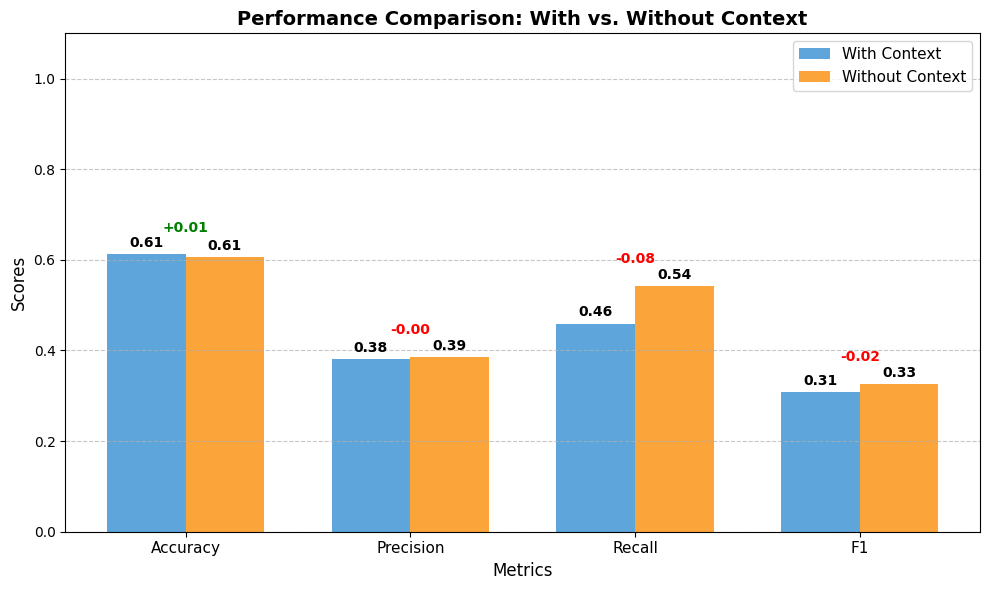

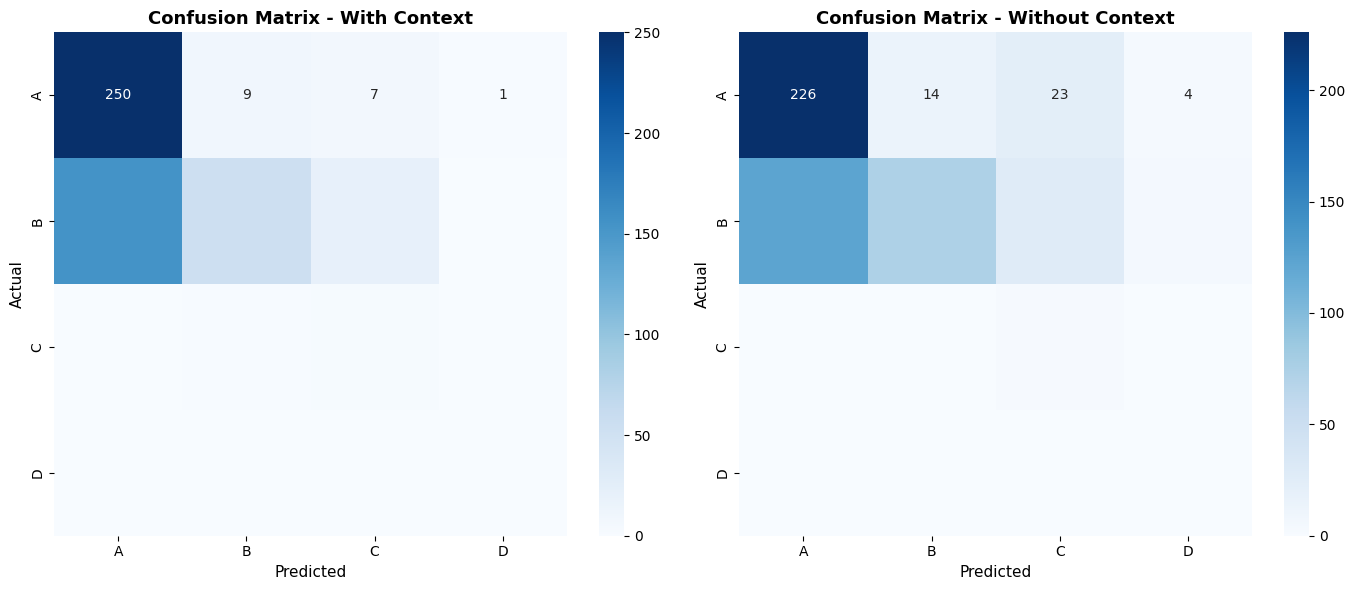

NameError: name 'Counter' is not defined

<Figure size 1000x600 with 0 Axes>

In [39]:
# Visualize metrics comparison
if with_context_metrics and without_context_metrics:
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    with_context_values = [with_context_metrics[m] for m in metrics]
    without_context_values = [without_context_metrics[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, with_context_values, width, label='With Context', color='#5DA5DA')
    rects2 = ax.bar(x + width/2, without_context_values, width, label='Without Context', color='#FAA43A')
    
    # Add labels and title
    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('Scores', fontsize=12)
    ax.set_title('Performance Comparison: With vs. Without Context', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([m.capitalize() for m in metrics], fontsize=11)
    ax.legend(fontsize=11)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10, fontweight='bold')
    
    add_labels(rects1)
    add_labels(rects2)
    
    # Add improvement percentages
    for i, metric in enumerate(metrics):
        improvement = with_context_values[i] - without_context_values[i]
        if improvement != 0:
            ax.annotate(f'{improvement:+.2f}',
                       xy=(i, max(with_context_values[i], without_context_values[i]) + 0.05),
                       ha='center',
                       color='green' if improvement > 0 else 'red',
                       fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize confusion matrices for multi-class (MCQ)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Get labels from the confusion matrices
    labels = sorted(set(valid_refs + valid_preds))
    
    # With context confusion matrix
    sns.heatmap(with_context_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=labels, yticklabels=labels)
    ax1.set_title('Confusion Matrix - With Context', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Predicted', fontsize=11)
    ax1.set_ylabel('Actual', fontsize=11)
    
    # Without context confusion matrix
    sns.heatmap(without_context_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=labels, yticklabels=labels)
    ax2.set_title('Confusion Matrix - Without Context', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Predicted', fontsize=11)
    ax2.set_ylabel('Actual', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Add class distribution visualization
    plt.figure(figsize=(10, 6))
    class_counts = Counter(valid_refs)
    class_labels = sorted(class_counts.keys())
    class_values = [class_counts[label] for label in class_labels]
    
    plt.bar(class_labels, class_values, color='#60BD68')
    plt.title('Distribution of Answer Classes in Dataset', fontsize=14, fontweight='bold')
    plt.xlabel('Answer Option', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count labels
    for i, v in enumerate(class_values):
        plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Add a per-class performance comparison
    # Extract per-class metrics from classification reports
    with_context_report = classification_report(valid_refs, valid_preds, labels=labels, output_dict=True)
    without_context_report = classification_report(valid_refs, valid_preds, labels=labels, output_dict=True)
    
    # Prepare data for plotting
    class_metrics = []
    for label in labels:
        if label in with_context_report and label in without_context_report:
            with_f1 = with_context_report[label]['f1-score']
            without_f1 = without_context_report[label]['f1-score']
            class_metrics.append({
                'class': label,
                'with_context': with_f1,
                'without_context': without_f1,
                'improvement': with_f1 - without_f1
            })
    
    if class_metrics:
        # Create DataFrame for easier plotting
        class_df = pd.DataFrame(class_metrics)
        
        # Plot per-class F1 scores
        plt.figure(figsize=(10, 6))
        
        x = np.arange(len(class_df))
        width = 0.35
        
        plt.bar(x - width/2, class_df['with_context'], width, label='With Context', color='#5DA5DA')
        plt.bar(x + width/2, class_df['without_context'], width, label='Without Context', color='#FAA43A')
        
        plt.xlabel('Answer Option', fontsize=12)
        plt.ylabel('F1 Score', fontsize=12)
        plt.title('F1 Score Comparison by Answer Option', fontsize=14, fontweight='bold')
        plt.xticks(x, class_df['class'])
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add improvement labels
        for i, row in enumerate(class_metrics):
            improvement = row['improvement']
            if improvement != 0:
                plt.annotate(f'{improvement:+.2f}',
                           xy=(i, max(row['with_context'], row['without_context']) + 0.05),
                           ha='center',
                           color='green' if improvement > 0 else 'red',
                           fontweight='bold')
        
        plt.tight_layout()
        plt.show()
else:
    print("Not enough data to visualize comparison")


Context Impact Summary:
Neutral: 250 questions (50.0%)
No Help: 141 questions (28.2%)
Positive: 56 questions (11.2%)
Negative: 53 questions (10.6%)

Net Positive Impact: 3 questions (0.6%)


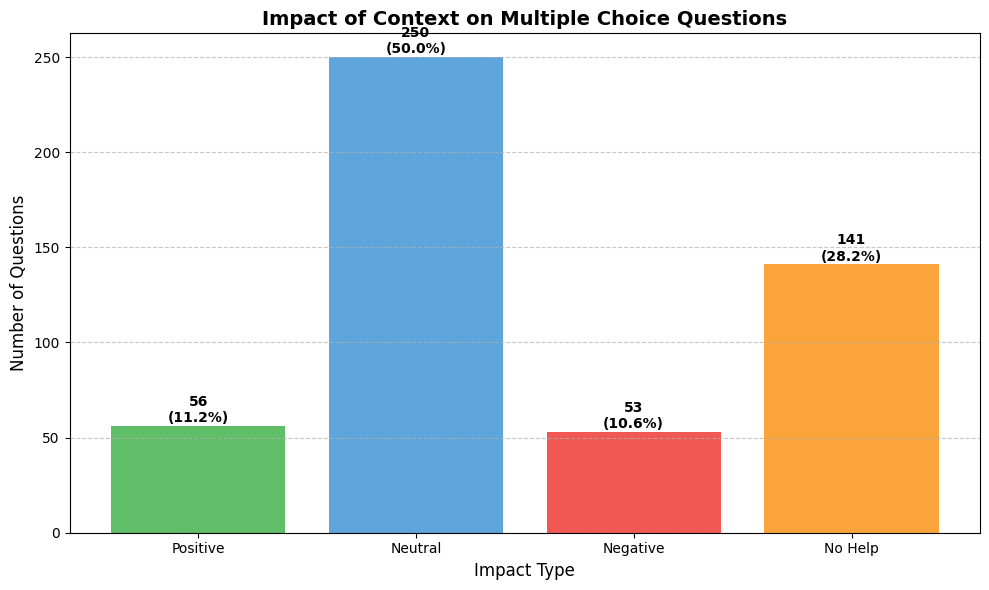


Feature Analysis for Context Impact:

Feature: is_cause_effect
  Questions with this feature: 76
  Positive impact rate: 9.2%
  Negative impact rate: 7.9%
  Net positive rate: 1.3%

Feature: mentions_specific_condition
  Questions with this feature: 225
  Positive impact rate: 4.9%
  Negative impact rate: 11.1%
  Net positive rate: -6.2%

Feature: mentions_therapy
  Questions with this feature: 56
  Positive impact rate: 25.0%
  Negative impact rate: 14.3%
  Net positive rate: 10.7%


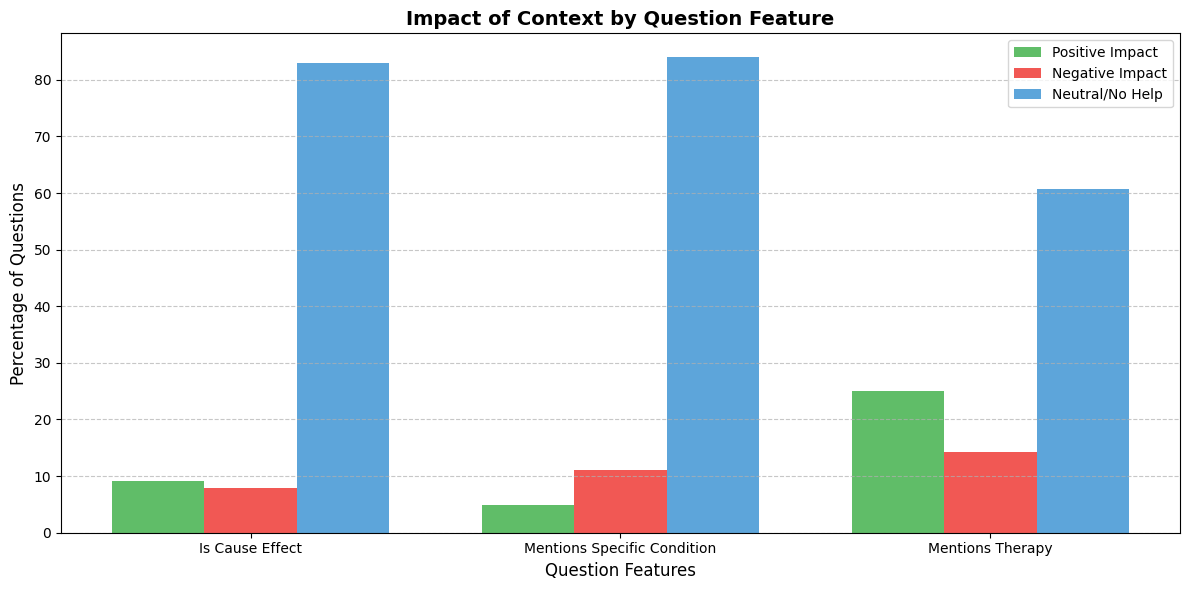

In [41]:
# Analyze the impact of context on each question
df['context_impact'] = None

for i, row in df.iterrows():
    # Get standardized answers for comparison
    ground_truth = row['standardized_answer']
    with_context = row['with_context_parsed']
    without_context = row['without_context_parsed']
    
    # Skip if ground truth or either prediction is None
    if ground_truth is None or with_context is None or without_context is None:
        df.at[i, 'context_impact'] = 'Unknown'
        continue
        
    with_correct = with_context == ground_truth
    without_correct = without_context == ground_truth
    
    if with_correct and not without_correct:
        df.at[i, 'context_impact'] = 'Positive'
    elif not with_correct and without_correct:
        df.at[i, 'context_impact'] = 'Negative'
    elif with_correct and without_correct:
        df.at[i, 'context_impact'] = 'Neutral'
    else:  # both incorrect
        df.at[i, 'context_impact'] = 'No Help'

# Summarize context impact
impact_counts = df['context_impact'].value_counts()
print("\nContext Impact Summary:")
for impact, count in impact_counts.items():
    percentage = count/len(df)*100
    print(f"{impact}: {count} questions ({percentage:.1f}%)")

# Calculate net positive impact
positive_count = impact_counts.get('Positive', 0)
negative_count = impact_counts.get('Negative', 0)
net_impact = positive_count - negative_count
net_percentage = net_impact / len(df) * 100
print(f"\nNet Positive Impact: {net_impact} questions ({net_percentage:.1f}%)")

# Visualize context impact with improved colors
plt.figure(figsize=(10, 6))
impact_order = ['Positive', 'Neutral', 'Negative', 'No Help', 'Unknown']
impact_colors = {
    'Positive': '#60BD68',  # Green
    'Neutral': '#5DA5DA',   # Blue
    'Negative': '#F15854',  # Red
    'No Help': '#FAA43A',   # Orange
    'Unknown': '#CCCCCC'    # Gray
}

# Reorder the data for consistent display
ordered_counts = []
ordered_labels = []
for impact in impact_order:
    if impact in impact_counts:
        ordered_counts.append(impact_counts[impact])
        ordered_labels.append(impact)

# Create the bar chart
bars = plt.bar(ordered_labels, ordered_counts, color=[impact_colors[impact] for impact in ordered_labels])
plt.title('Impact of Context on Multiple Choice Questions', fontsize=14, fontweight='bold')
plt.xlabel('Impact Type', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count and percentage labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = height/len(df)*100
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Additional analysis: When does context help vs. hurt?
# Create a function to extract key features from questions
def extract_features(question):
    features = {}
    # Check for question types
    features['is_cause_effect'] = 'cause' in question.lower() or 'because' in question.lower() or 'due to' in question.lower()
    features['mentions_specific_condition'] = any(word in question.lower() for word in ['diabetes', 'hypertension', 'obesity', 'smoking'])
    features['mentions_therapy'] = any(word in question.lower() for word in ['therapy', 'treatment', 'surgery', 'injection'])
    features['about_disease_mechanism'] = 'mechanism' in question.lower() or 'pathway' in question.lower()
    return features

# Apply feature extraction
for i, row in df.iterrows():
    features = extract_features(row['question'])
    for feature, value in features.items():
        df.at[i, feature] = value

# Analyze which features correlate with positive context impact
print("\nFeature Analysis for Context Impact:")
features = ['is_cause_effect', 'mentions_specific_condition', 'mentions_therapy', 'about_disease_mechanism']

for feature in features:
    positive_with_feature = df[(df['context_impact'] == 'Positive') & (df[feature] == True)].shape[0]
    total_with_feature = df[df[feature] == True].shape[0]
    
    negative_with_feature = df[(df['context_impact'] == 'Negative') & (df[feature] == True)].shape[0]
    
    if total_with_feature > 0:
        positive_rate = positive_with_feature / total_with_feature * 100
        negative_rate = negative_with_feature / total_with_feature * 100
        print(f"\nFeature: {feature}")
        print(f"  Questions with this feature: {total_with_feature}")
        print(f"  Positive impact rate: {positive_rate:.1f}%")
        print(f"  Negative impact rate: {negative_rate:.1f}%")
        print(f"  Net positive rate: {positive_rate - negative_rate:.1f}%")

# Visualize the feature analysis
feature_data = []
for feature in features:
    positive_count = df[(df['context_impact'] == 'Positive') & (df[feature] == True)].shape[0]
    negative_count = df[(df['context_impact'] == 'Negative') & (df[feature] == True)].shape[0]
    total_count = df[df[feature] == True].shape[0]
    
    if total_count > 0:
        feature_data.append({
            'feature': feature.replace('_', ' ').title(),
            'positive_rate': positive_count / total_count * 100,
            'negative_rate': negative_count / total_count * 100,
            'neutral_rate': (total_count - positive_count - negative_count) / total_count * 100
        })

if feature_data:
    feature_df = pd.DataFrame(feature_data)
    
    # Plot the feature analysis
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(feature_df))
    width = 0.25
    
    plt.bar(x - width, feature_df['positive_rate'], width, label='Positive Impact', color='#60BD68')
    plt.bar(x, feature_df['negative_rate'], width, label='Negative Impact', color='#F15854')
    plt.bar(x + width, feature_df['neutral_rate'], width, label='Neutral/No Help', color='#5DA5DA')
    
    plt.xlabel('Question Features', fontsize=12)
    plt.ylabel('Percentage of Questions', fontsize=12)
    plt.title('Impact of Context by Question Feature', fontsize=14, fontweight='bold')
    plt.xticks(x, feature_df['feature'])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [42]:
# Generate a summary report
print("\n" + "=" * 80)
print("EVALUATION SUMMARY REPORT - MULTIPLE CHOICE QUESTIONS")
print("=" * 80)

# Count valid questions and answers
valid_questions = df['standardized_answer'].notna().sum()
total_questions = len(df)

print(f"Total Questions: {total_questions}")
print(f"Questions with Valid Ground Truth: {valid_questions} ({valid_questions/total_questions*100:.1f}%)")

# Count distribution of answers
if valid_questions > 0:
    answer_counts = df['standardized_answer'].value_counts()
    print("\nDistribution of Ground Truth Answers:")
    for answer, count in answer_counts.items():
        print(f"  Option {answer}: {count} questions ({count/valid_questions*100:.1f}%)")

# Performance metrics
print("\nPerformance Summary:")
if with_context_metrics and without_context_metrics:
    print(f"With Context Accuracy: {with_context_metrics['accuracy']:.2f} ({with_context_metrics['accuracy']*100:.1f}%)")
    print(f"Without Context Accuracy: {without_context_metrics['accuracy']:.2f} ({without_context_metrics['accuracy']*100:.1f}%)")
    print(f"With Context Macro F1: {with_context_metrics['f1']:.2f}")
    print(f"Without Context Macro F1: {without_context_metrics['f1']:.2f}")
    
    # Determine if context helped overall
    if with_context_metrics['accuracy'] > without_context_metrics['accuracy']:
        diff = with_context_metrics['accuracy'] - without_context_metrics['accuracy']
        rel_improvement = diff / without_context_metrics['accuracy'] * 100
        print(f"\nContext improved accuracy by {diff:.2f} ({diff*100:.1f}% absolute, {rel_improvement:.1f}% relative)")
    elif with_context_metrics['accuracy'] < without_context_metrics['accuracy']:
        diff = without_context_metrics['accuracy'] - with_context_metrics['accuracy']
        rel_decline = diff / with_context_metrics['accuracy'] * 100
        print(f"\nContext decreased accuracy by {diff:.2f} ({diff*100:.1f}% absolute, {rel_decline:.1f}% relative)")
    else:
        print("\nContext had no overall impact on accuracy")

# Context impact summary
print("\nContext Impact Analysis:")
for impact, count in impact_counts.items():
    print(f"  {impact}: {count} questions ({count/total_questions*100:.1f}%)")

# Calculate net positive ratio
positive_count = impact_counts.get('Positive', 0)
negative_count = impact_counts.get('Negative', 0)
if positive_count + negative_count > 0:
    positive_ratio = positive_count / (positive_count + negative_count)
    print(f"\nPositive-to-Negative Impact Ratio: {positive_ratio:.2f} ({positive_count}:{negative_count})")

# Per-option performance
print("\nPer-Option Performance (With Context):")
# Create a dictionary to store per-option accuracy
option_metrics = {}

# Identify options present in the dataset
all_options = set(df['standardized_answer'].dropna())

# Calculate metrics for each option
for option in all_options:
    option_indices = df[df['standardized_answer'] == option].index
    correct_count = sum(1 for i in option_indices if df.loc[i, 'with_context_parsed'] == option)
    total_count = len(option_indices)
    if total_count > 0:
        accuracy = correct_count / total_count
        option_metrics[option] = {
            'accuracy': accuracy,
            'count': total_count,
            'correct': correct_count
        }

# Display per-option metrics
for option in sorted(option_metrics.keys()):
    metrics = option_metrics[option]
    print(f"  Option {option}: {metrics['accuracy']:.2f} accuracy ({metrics['correct']}/{metrics['count']} correct)")

# List top 5 questions where context helped (max 5)
helped_questions = df[df['context_impact'] == 'Positive'].head(5)
if not helped_questions.empty:
    print("\nSample Questions Where Context Helped:")
    for i, row in helped_questions.iterrows():
        print(f"- Q{i}: {row['question']}")
        print(f"  Ground Truth: {row['standardized_answer']}")
        print(f"  With Context: {row['with_context_parsed']} | Without Context: {row['without_context_parsed']}")

# List top 5 questions where context was misleading (max 5)
misled_questions = df[df['context_impact'] == 'Negative'].head(5)
if not misled_questions.empty:
    print("\nSample Questions Where Context Was Misleading:")
    for i, row in misled_questions.iterrows():
        print(f"- Q{i}: {row['question']}")
        print(f"  Ground Truth: {row['standardized_answer']}")
        print(f"  With Context: {row['with_context_parsed']} | Without Context: {row['without_context_parsed']}")

# Conclusions
print("\nConclusions:")
print("1. Context retrieval" + 
      (" improved " if with_context_metrics.get('accuracy', 0) > without_context_metrics.get('accuracy', 0) else " did not improve ") + 
      "overall accuracy for multiple choice questions.")

print(f"2. {impact_counts.get('Positive', 0)} questions benefited from context, while {impact_counts.get('Negative', 0)} questions were negatively affected.")

# Per-option performance insights
best_option = max(option_metrics.items(), key=lambda x: x[1]['accuracy'])[0] if option_metrics else None
worst_option = min(option_metrics.items(), key=lambda x: x[1]['accuracy'])[0] if option_metrics else None

if best_option and worst_option:
    print(f"3. Performance varied by answer option: Option {best_option} had the highest accuracy, while Option {worst_option} had the lowest.")

# Recommendations
print("\nRecommendations:")
if with_context_metrics.get('accuracy', 0) > without_context_metrics.get('accuracy', 0):
    print("1. Continue using RAG for multiple choice questions, with focus on improving quality of retrieved contexts.")
    print("2. Consider a hybrid approach that evaluates context quality before deciding whether to use it.")
    print(f"3. Pay special attention to questions where option {worst_option} is the correct answer, as these showed lower accuracy.")
else:
    print("1. Review and improve context retrieval quality for multiple choice questions.")
    print("2. Consider limiting RAG to specific types of questions where context has shown to be helpful.")
    print("3. For questions with poor context performance, consider reverting to model-only answers.")

print("4. Expand the evaluation dataset to include more diverse multiple choice question types.")
print("5. Further analyze questions where context was misleading to identify patterns and potential improvements.")


EVALUATION SUMMARY REPORT - MULTIPLE CHOICE QUESTIONS
Total Questions: 500
Questions with Valid Ground Truth: 500 (100.0%)

Distribution of Ground Truth Answers:
  Option A: 267 questions (53.4%)
  Option B: 230 questions (46.0%)
  Option C: 3 questions (0.6%)

Performance Summary:
With Context Accuracy: 0.61 (61.2%)
Without Context Accuracy: 0.61 (60.6%)
With Context Macro F1: 0.31
Without Context Macro F1: 0.33

Context improved accuracy by 0.01 (0.6% absolute, 1.0% relative)

Context Impact Analysis:
  Neutral: 250 questions (50.0%)
  No Help: 141 questions (28.2%)
  Positive: 56 questions (11.2%)
  Negative: 53 questions (10.6%)

Positive-to-Negative Impact Ratio: 0.51 (56:53)

Per-Option Performance (With Context):
  Option A: 0.94 accuracy (250/267 correct)
  Option B: 0.23 accuracy (54/230 correct)
  Option C: 0.67 accuracy (2/3 correct)

Sample Questions Where Context Helped:
- Q52: Does family history elevate AMD risk by causing retinal pigment epithelial lipid repair? a) Yes